# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- 18/0013637 Arthur Paiva Tavares
- 17/0031538 Dâmaso Júnio pereira Brasileo
- 18/0063723 Fellipe dos Santos Araujo
- 15/0135939 Letícia Karla Araújo
- 20/0057227 Caio Vitor de Oliveira
- 20/0036351 Clara Marcelino de Sousa
- 20/0030469 Felipe Candido de Moura
- 19/0091720 Lucas macedo Barboza
- 20/0023411 Luíza Esteves dos Santos
- 20/0041959 Maurício Machado Filho
- 19/0037806 Samuel Furtado Avila

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here
print(jsons[0])

../analytics-raw-data/fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2022-15-28-02-v2.1.1-devel.0.json


In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"Eu-Pescador-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
0,duplicated_lines_density,0.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
1,functions,20,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
2,test_execution_time,122,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
3,test_failures,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
4,test_errors,0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
5,security_rating,1.0,True,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
6,tests,23,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
7,files,8,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
8,complexity,46,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
9,ncloc,384,NaN,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL' or component['qualifier'] == 'UTS':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)
        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"Eu-Pescador-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,tests,test_errors,test_failures,test_execution_time,security_rating,filename,repository,version
0,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
1,src/middleware/auth.ts,3,5,0.0,0.0,38.9,31,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
2,src/config/database.ts,2,4,0.0,0.0,0.0,27,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
3,src/models/fishLog.ts,0,0,0.0,0.0,100.0,94,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
4,test/controller/fishLogController.spec.ts,NaN,NaN,NaN,0.0,NaN,NaN,23,0,0,122,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
5,src/controllers/fishLogController.ts,8,29,0.0,0.0,84.7,186,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
6,src/routes/fishLogRoutes.ts,6,6,0.0,0.0,0.0,25,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
7,src/routes/router.ts,0,0,16.7,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
8,src/server.ts,1,2,0.0,0.0,0.0,5,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishLog-03-18-2...,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0
27,src/app.ts,0,0,0.0,0.0,0.0,11,NaN,0,0,NaN,1.0,fga-eps-mds-2021.2-Eu-Pescador-FishWiki-03-18-...,FishWiki,03-18-2022-00-13-24-v2.0.5-devel.0


#### Create dataframe per repository

In [12]:
repo1_df = file_component_df[file_component_df['repository'] == 'UserInterface']
repo2_df = file_component_df[file_component_df['repository'] == 'User']
repo3_df = file_component_df[file_component_df['repository'] == 'FishWiki']
repo4_df = file_component_df[file_component_df['repository'] == 'FishLog']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

##### Function to filter files from glob string

In [14]:
import fnmatch
import glob
import os.path
from itertools import product


# Cross-Python dictionary views on the keys 
if hasattr(dict, 'viewkeys'):
    # Python 2
    def _viewkeys(d):
        return d.viewkeys()
else:
    # Python 3
    def _viewkeys(d):
        return d.keys()


def _in_trie(trie, path):
    """Determine if path is completely in trie"""
    current = trie
    for elem in path:
        try:
            current = current[elem]
        except KeyError:
            return False
    return None in current


def find_matching_paths(paths, pattern):
    """Produce a list of paths that match the pattern.

    * paths is a list of strings representing filesystem paths
    * pattern is a glob pattern as supported by the fnmatch module

    """
    if os.altsep:  # normalise
        pattern = pattern.replace(os.altsep, os.sep)
    pattern = pattern.split(os.sep)

    # build a trie out of path elements; efficiently search on prefixes
    path_trie = {}
    for path in paths:
        if os.altsep:  # normalise
            path = path.replace(os.altsep, os.sep)
        _, path = os.path.splitdrive(path)
        elems = path.split(os.sep)
        current = path_trie
        for elem in elems:
            current = current.setdefault(elem, {})
        current.setdefault(None, None)  # sentinel

    matching = []

    current_level = [path_trie]
    for subpattern in pattern:
        if not glob.has_magic(subpattern):
            # plain element, element must be in the trie or there are
            # 0 matches
            if not any(subpattern in d for d in current_level):
                return []
            matching.append([subpattern])
            current_level = [d[subpattern] for d in current_level if subpattern in d]
        else:
            # match all next levels in the trie that match the pattern
            matched_names = fnmatch.filter({k for d in current_level for k in d}, subpattern)
            if not matched_names:
                # nothing found
                return []
            matching.append(matched_names)
            current_level = [d[n] for d in current_level for n in _viewkeys(d) & set(matched_names)]

    return [os.sep.join(p) for p in product(*matching)
            if _in_trie(path_trie, p)]

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [15]:
def m1(df):
    invalid_complexity_value = 0
    for index, row in df.iterrows():
        if pd.isna(row['complexity']) or pd.isna(row['functions']):
            invalid_complexity_value += 1
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/max(len(df) - invalid_complexity_value, 1)
    
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    
    density_of_commented_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_of_commented_files

##### DUPLICATIONS

In [17]:
def m3(df):
    
    absence_of_duplications = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return absence_of_duplications

# Quality Aspect - Reliability
## Factor - Testing Status

##### Errors tests

In [18]:
def m4(df):

    passed_tests = df[pd.notna(df['test_errors'])]['test_errors'].astype(float).median() / 100

    return passed_tests

##### Failure tests

In [19]:
def m5(df):

    passed_tests = df[pd.notna(df['test_failures'])]['test_failures'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [20]:
def m6(df):
    fast_tests_files = df[(pd.notna(df['test_execution_time'])) & ((df['test_execution_time'].astype(float)) < 300)]
    qnt_fast_tests_per_file = sum(fast_tests_files['tests'].astype(float))
    density_fast_test_builds = len(fast_tests_files) * qnt_fast_tests_per_file / sum(df[(pd.notna(df['tests']))]['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [21]:
def m7(df):
    invalid_paths = ["test/**/*.spec.ts", "**/test/**/*.spec.ts", "**test/**/*.spec.ts", "src/app.ts", "src/server.ts", "src/routes/router.ts", "src/config/database.ts"]
    invalid_test_value = 0
    paths = []
    for index, row in df.iterrows():
        if pd.isna(row['coverage']):
            invalid_test_value += 1
        else:
            paths.append(row['path'])

    for pattern in invalid_paths:
        matching = find_matching_paths(paths, pattern)
        invalid_test_value += len(matching)

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / max((len(df) - invalid_test_value), 1)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [22]:
def create_metrics_df(df):
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []
    m7_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    for version in version_vec:
        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))
        m7_list.append(m7(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'm7': m7_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [26]:
create_metrics_df(repo1_df)

,m1,m2,m3,m4,m5,m6,m7,repository,version,ncloc
0,0.870588,0.034884,0.883721,0.0,0.0,1.0,0.0,UserInterface,03-18-2022-15-08-02-v1.1.3-devel.0,5458


In [23]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)

### Data visualization

- You must do this for each of your repositories

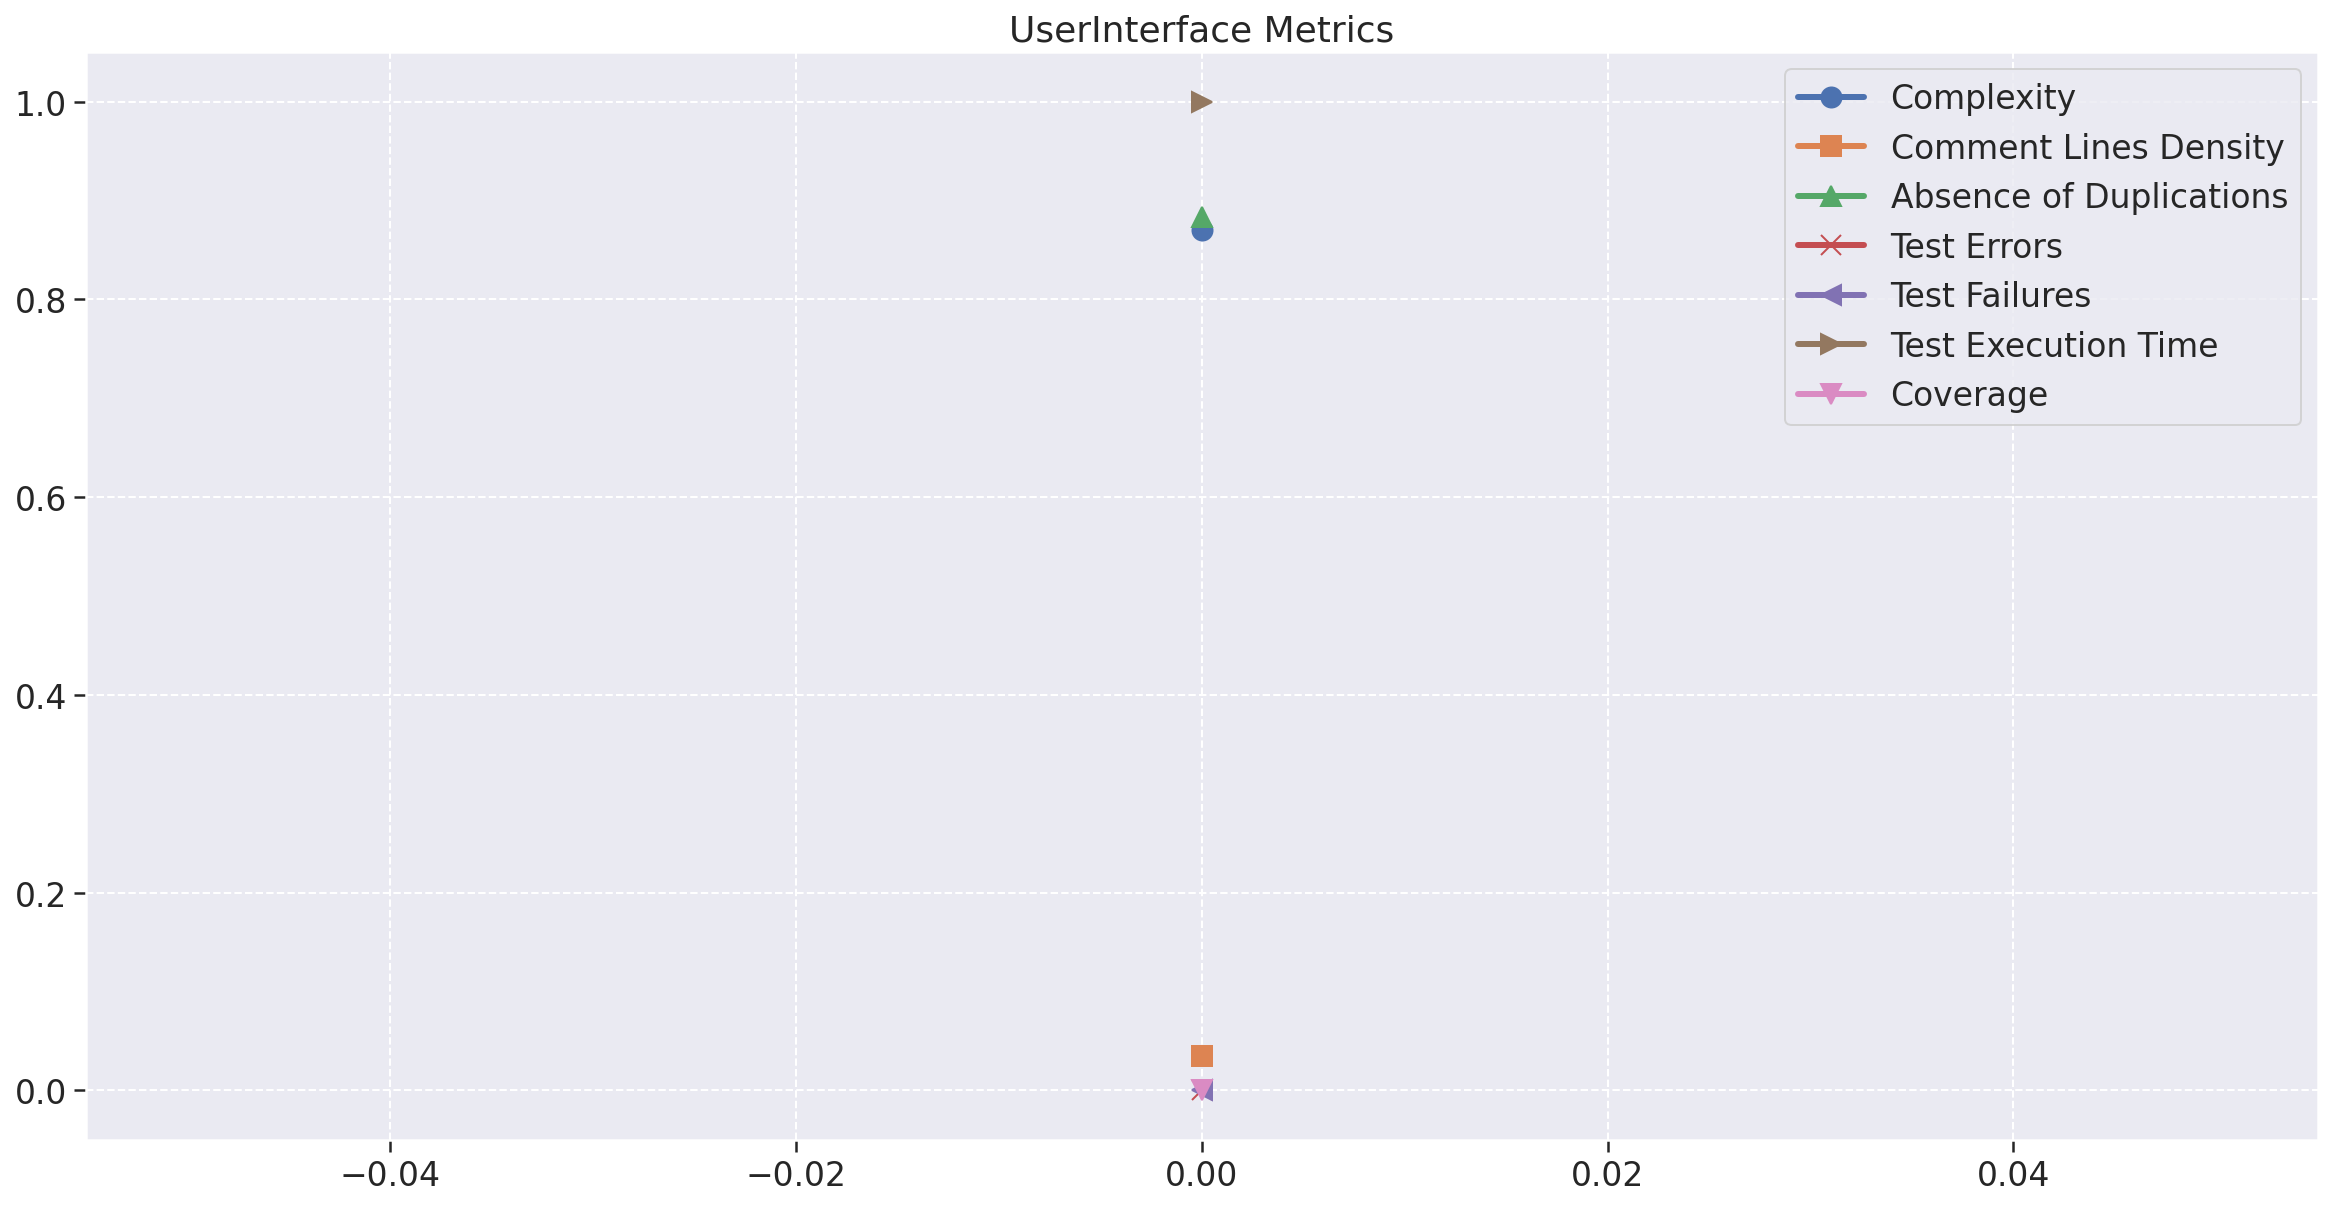

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('UserInterface Metrics')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo1_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo1_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo1_metrics['m7'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

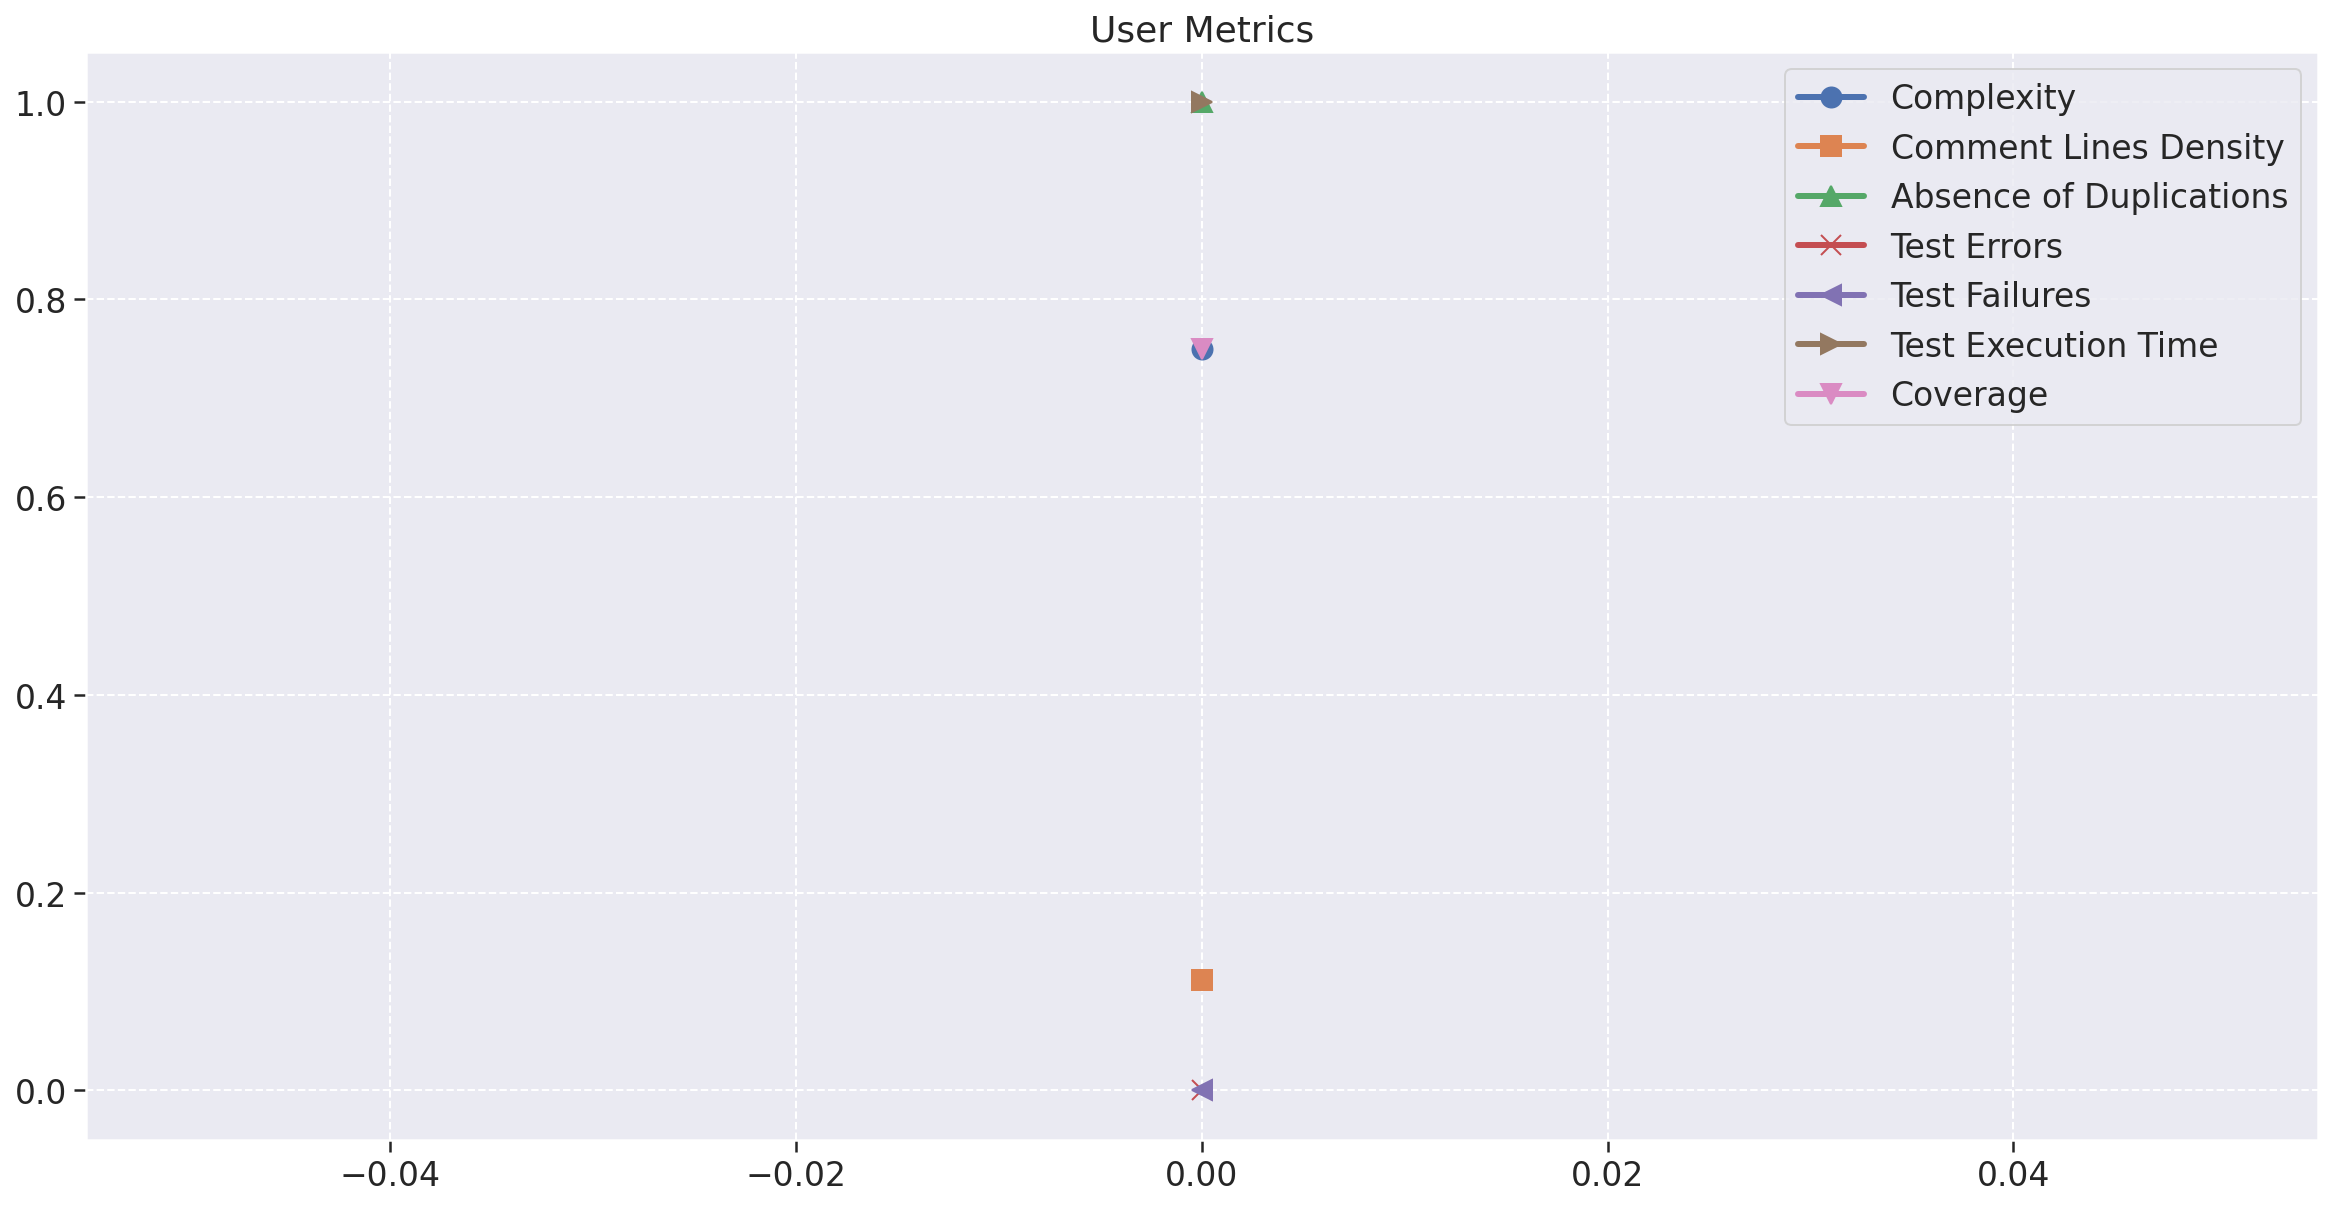

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('User Metrics')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo2_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo2_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo2_metrics['m7'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

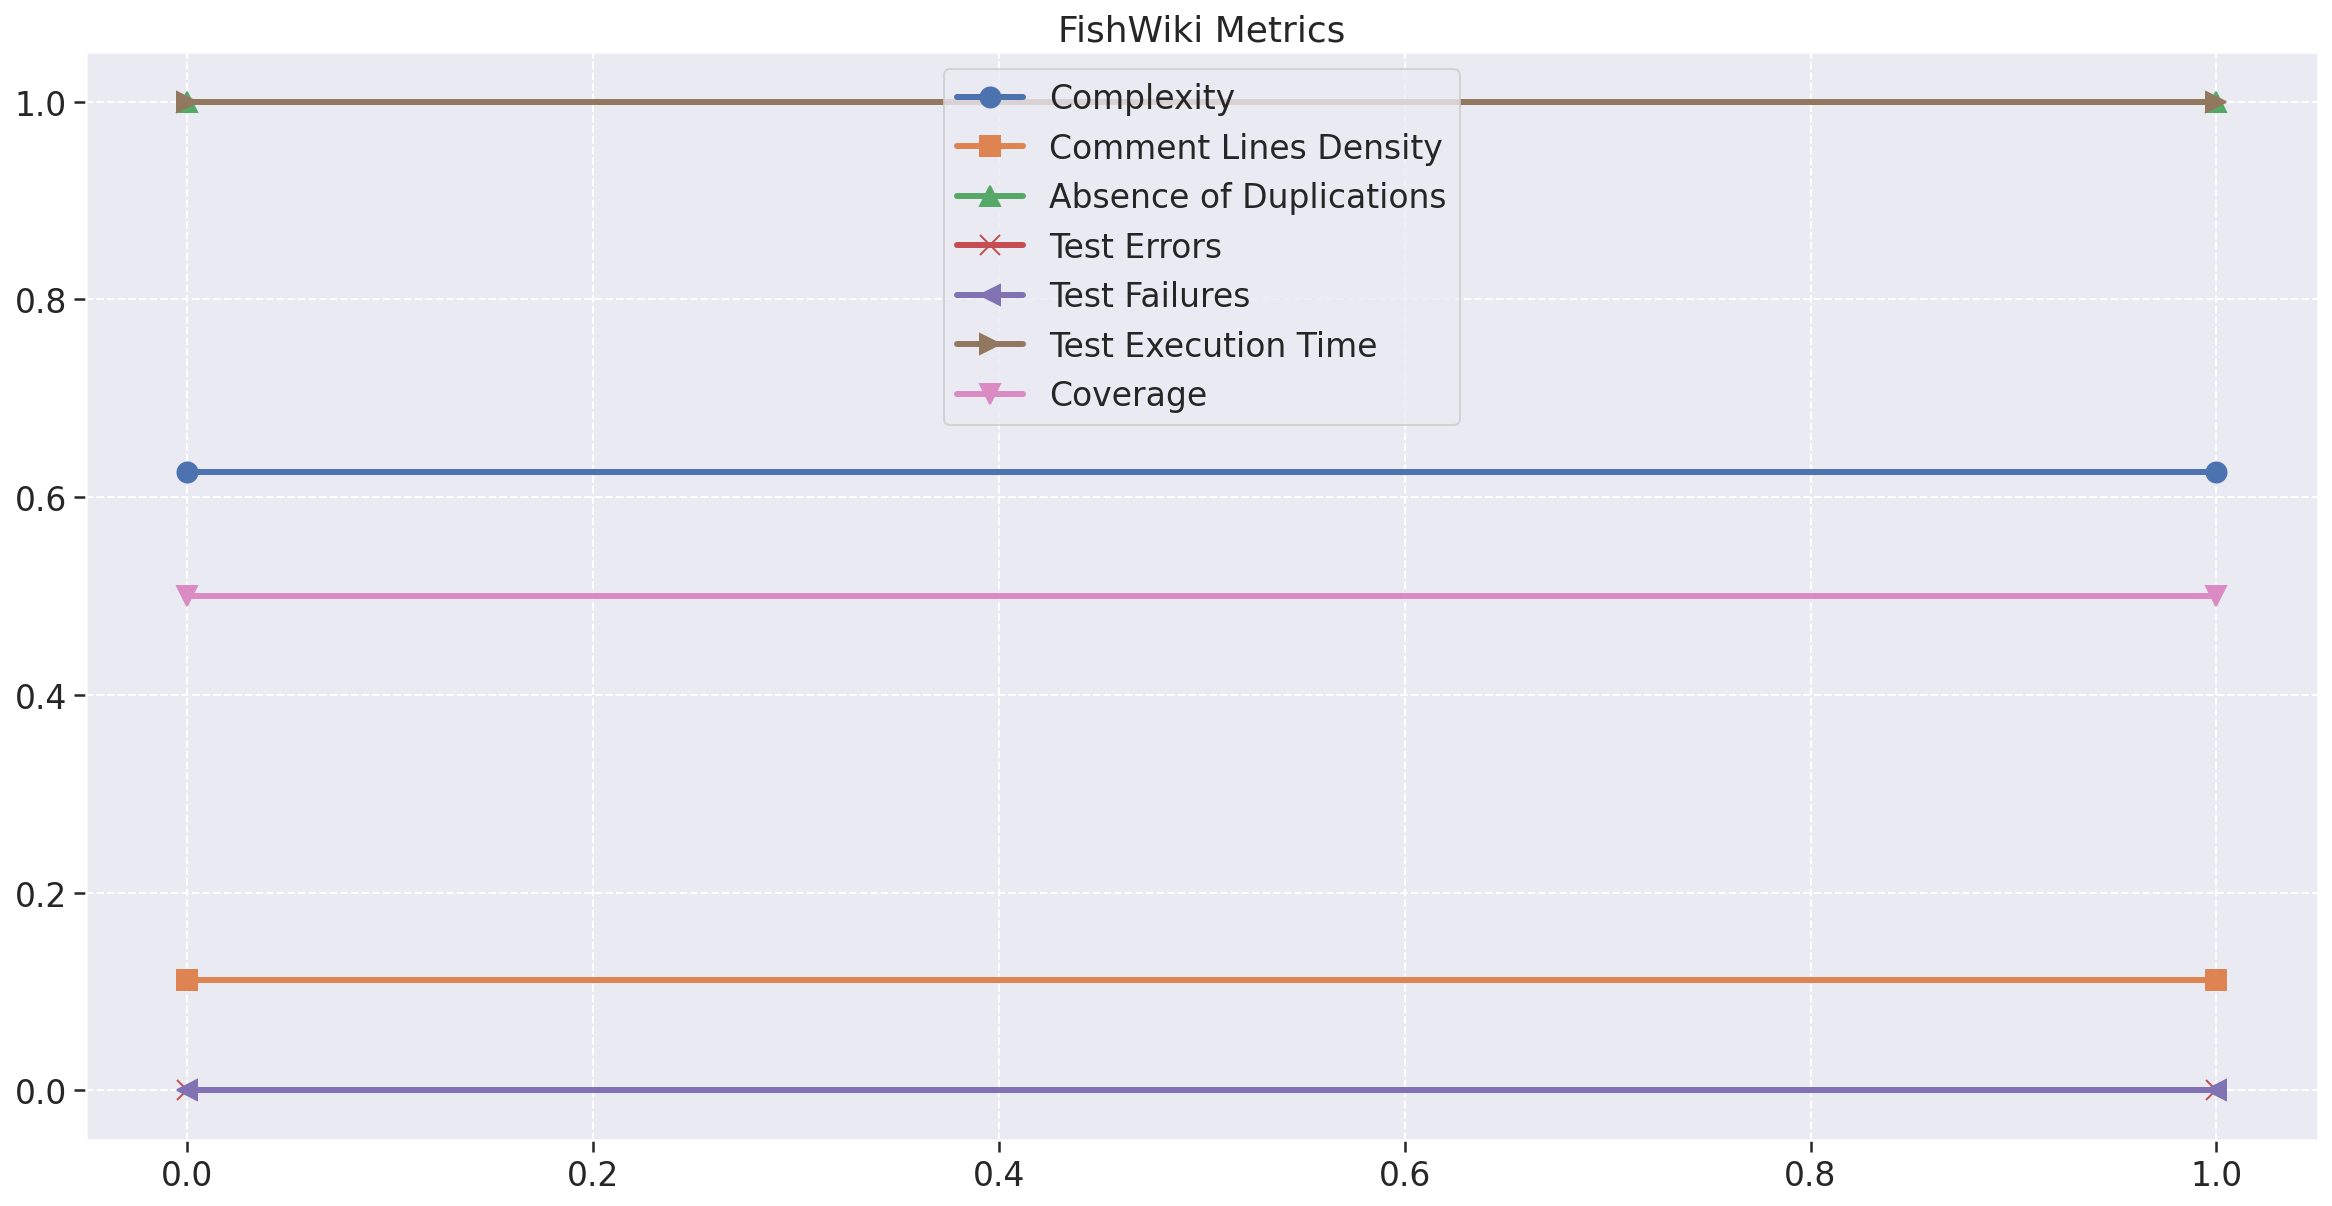

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishWiki Metrics')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo3_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo3_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo3_metrics['m7'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

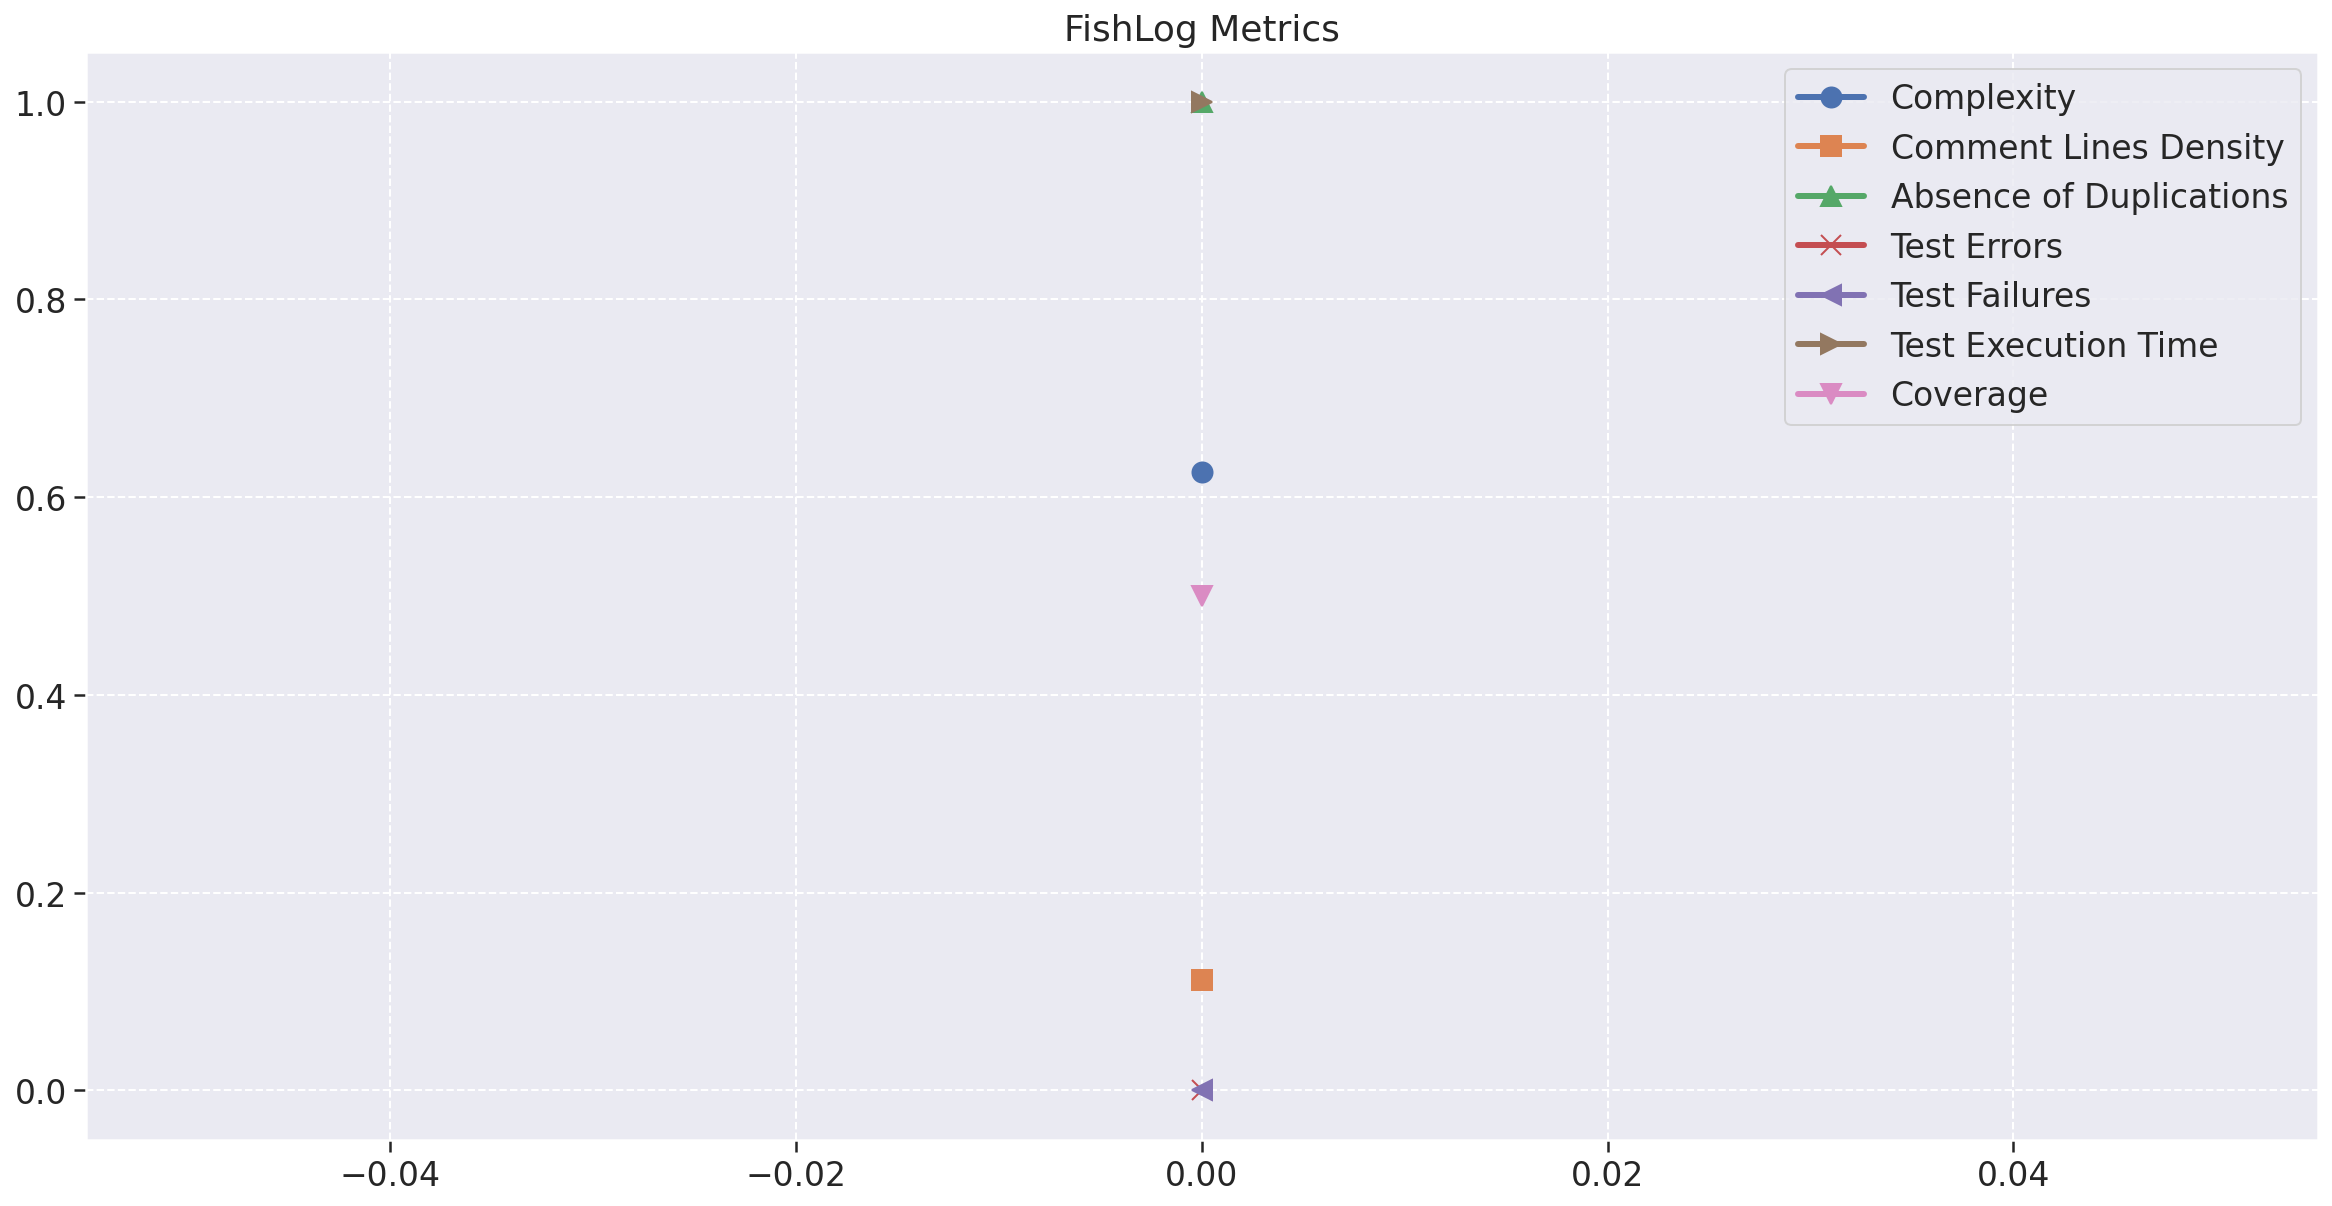

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.title('FishLog Metrics')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo4_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo4_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.plot(repo4_metrics['m7'], linewidth=3, marker='v', label='Coverage', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [29]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.15
pm7 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = ((repo1_metrics['m4']*pm4) + (repo1_metrics['m5']*pm5) + (repo1_metrics['m6']*pm6) + (repo1_metrics['m7']*pm7)) * psc2
repo2_metrics['testing_status'] = ((repo2_metrics['m4']*pm4) + (repo2_metrics['m5']*pm5) + (repo2_metrics['m6']*pm6) + (repo2_metrics['m7']*pm7)) * psc2
repo3_metrics['testing_status'] = ((repo3_metrics['m4']*pm4) + (repo3_metrics['m5']*pm5) + (repo3_metrics['m6']*pm6) + (repo3_metrics['m7']*pm7)) * psc2
repo4_metrics['testing_status'] = ((repo4_metrics['m4']*pm4) + (repo4_metrics['m5']*pm5) + (repo4_metrics['m6']*pm6) + (repo4_metrics['m7']*pm7)) * psc2


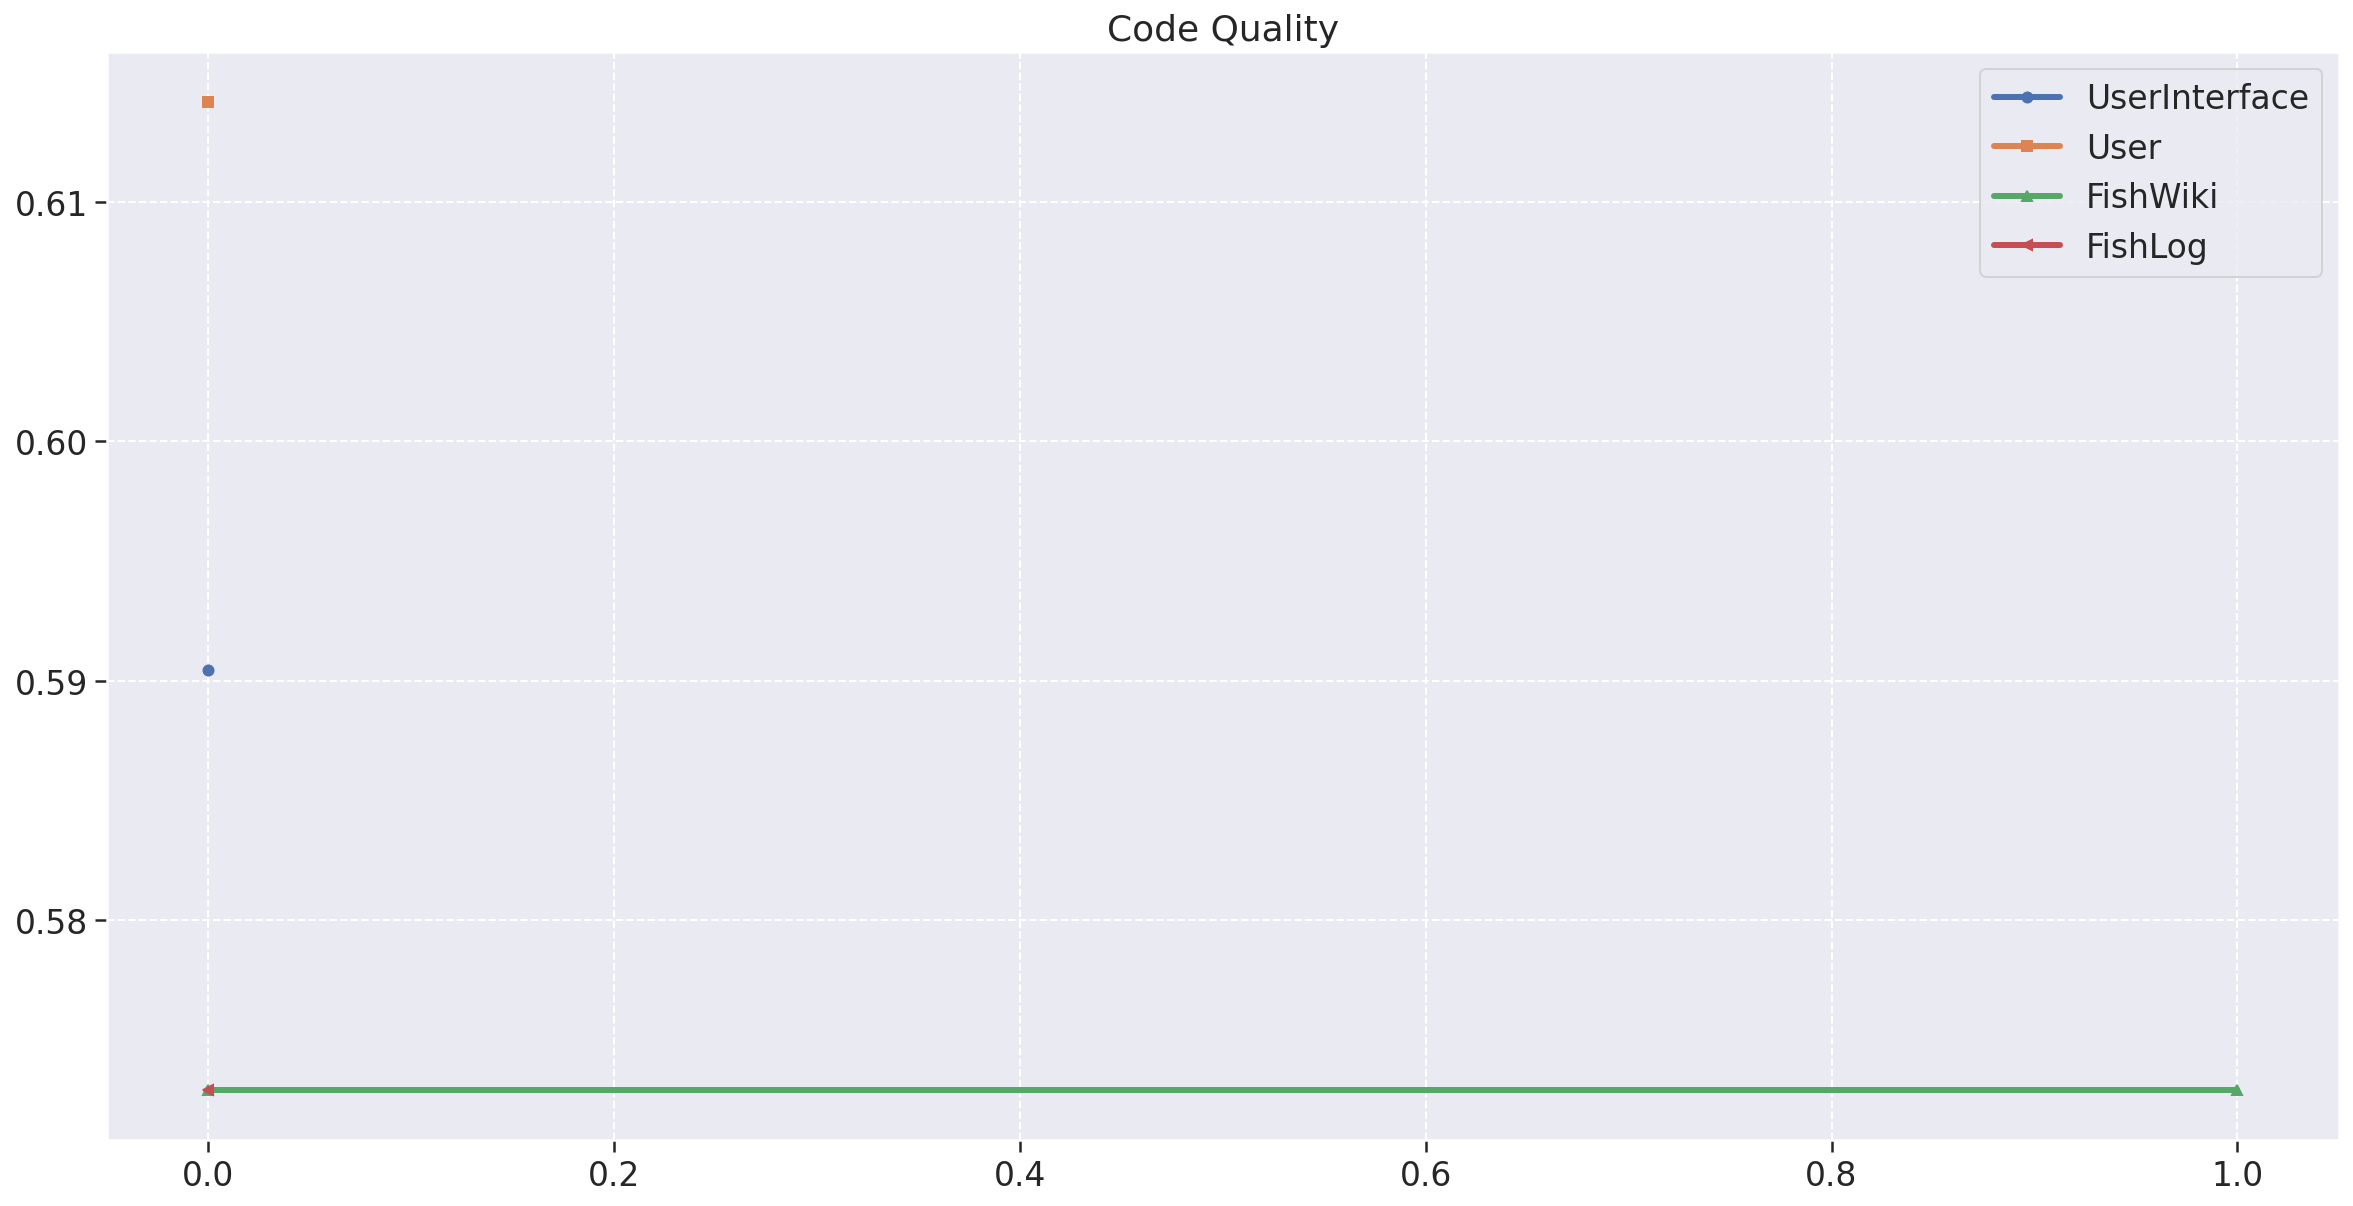

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

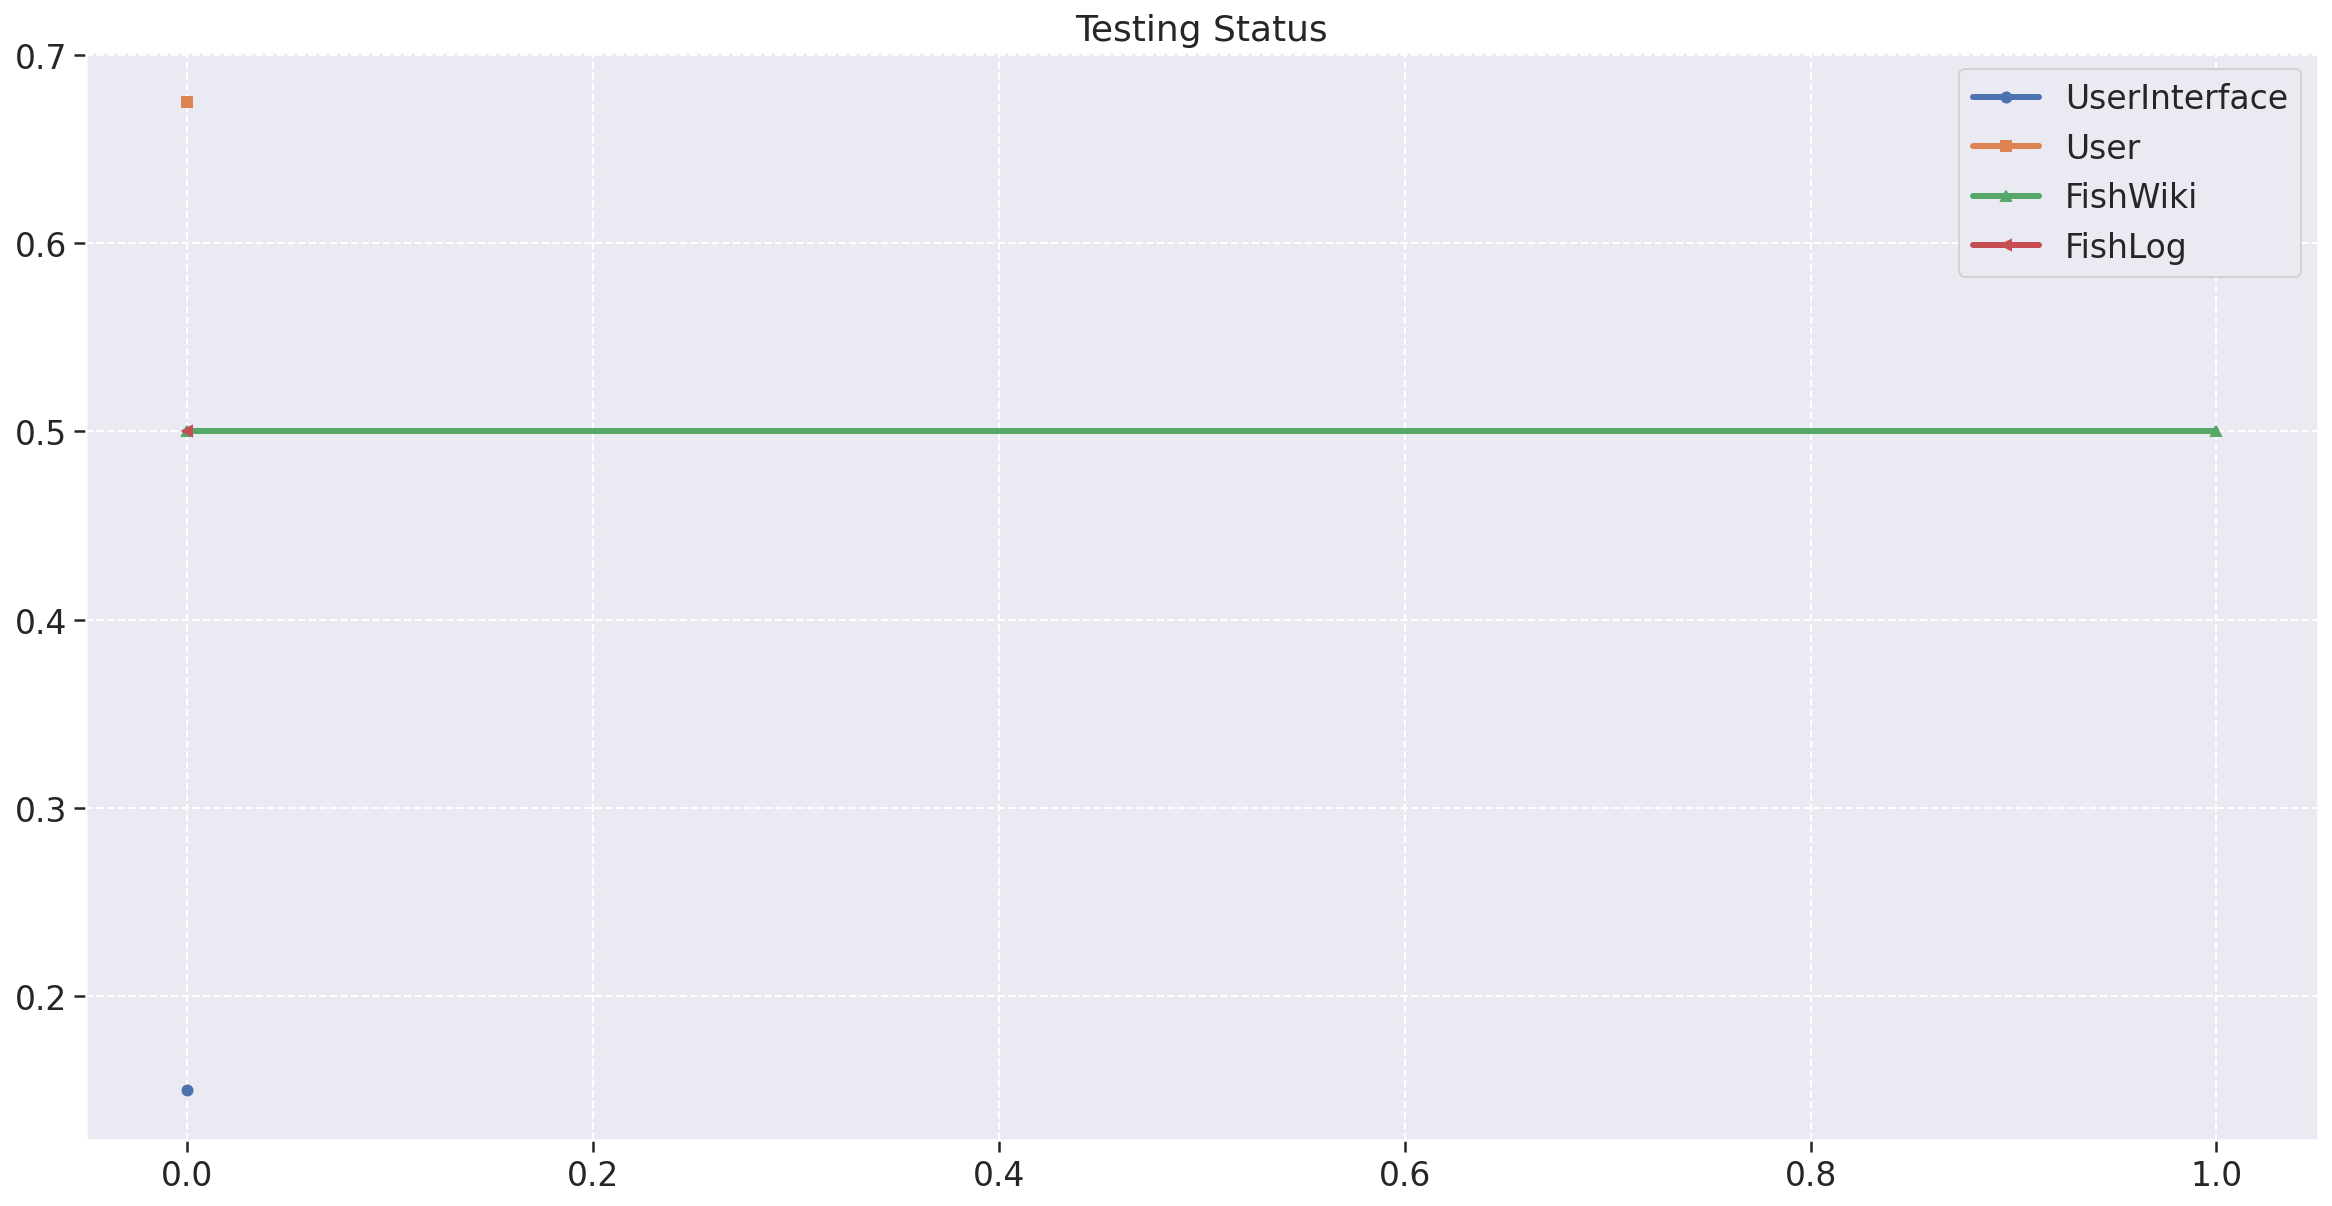

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='UserInterface', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='User', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='FishWiki', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='FishLog', markersize=5)
plt.legend()

In [32]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['reliability']

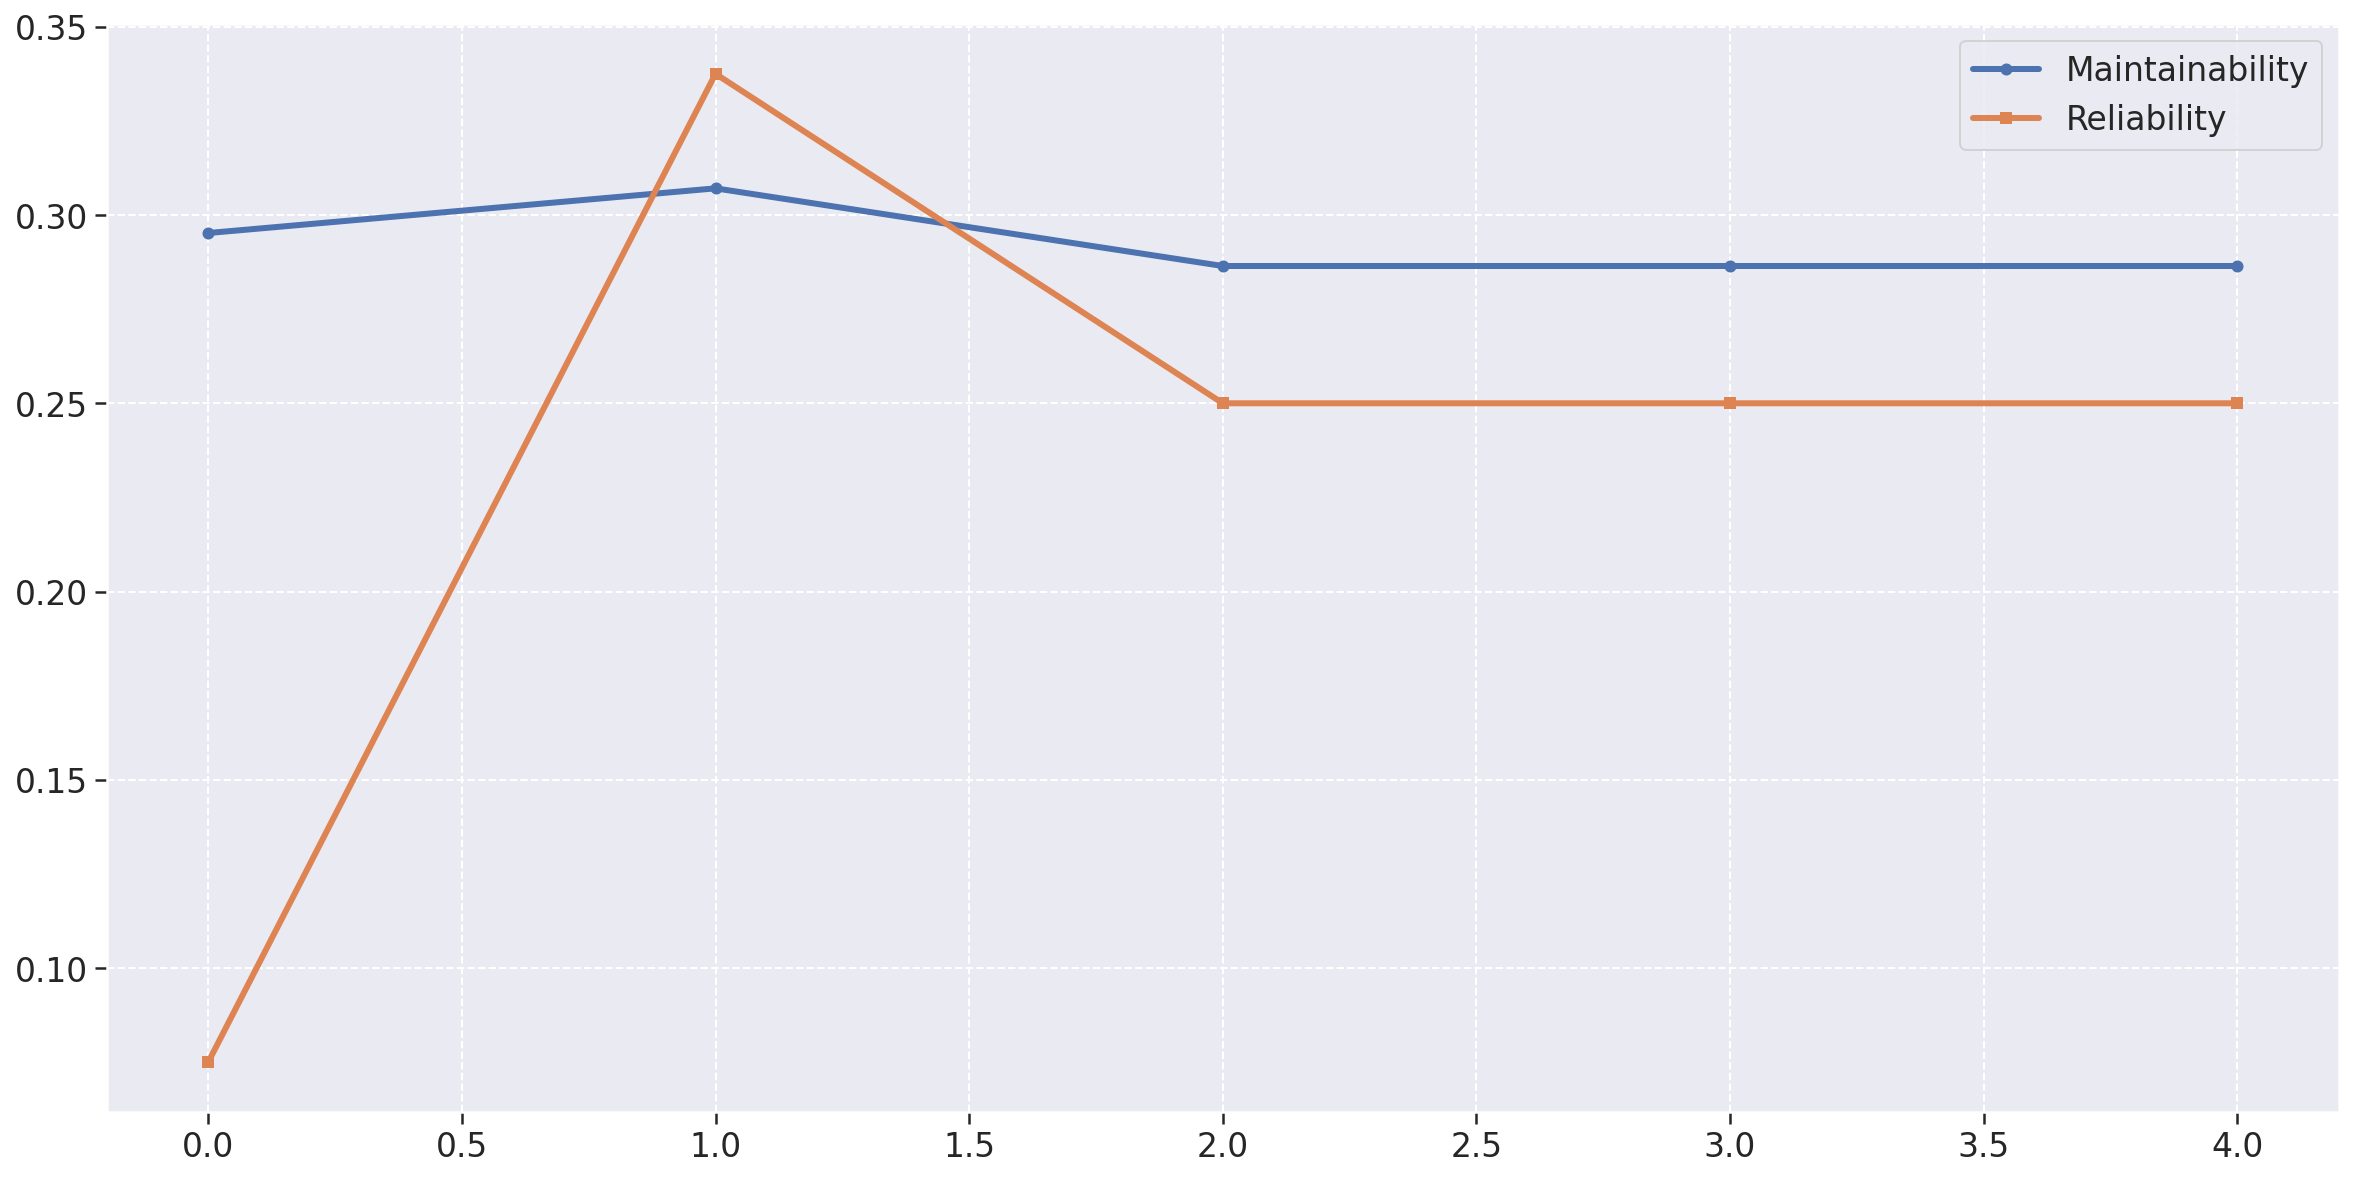

In [33]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.legend()
# plt.ylim(.2,.6)

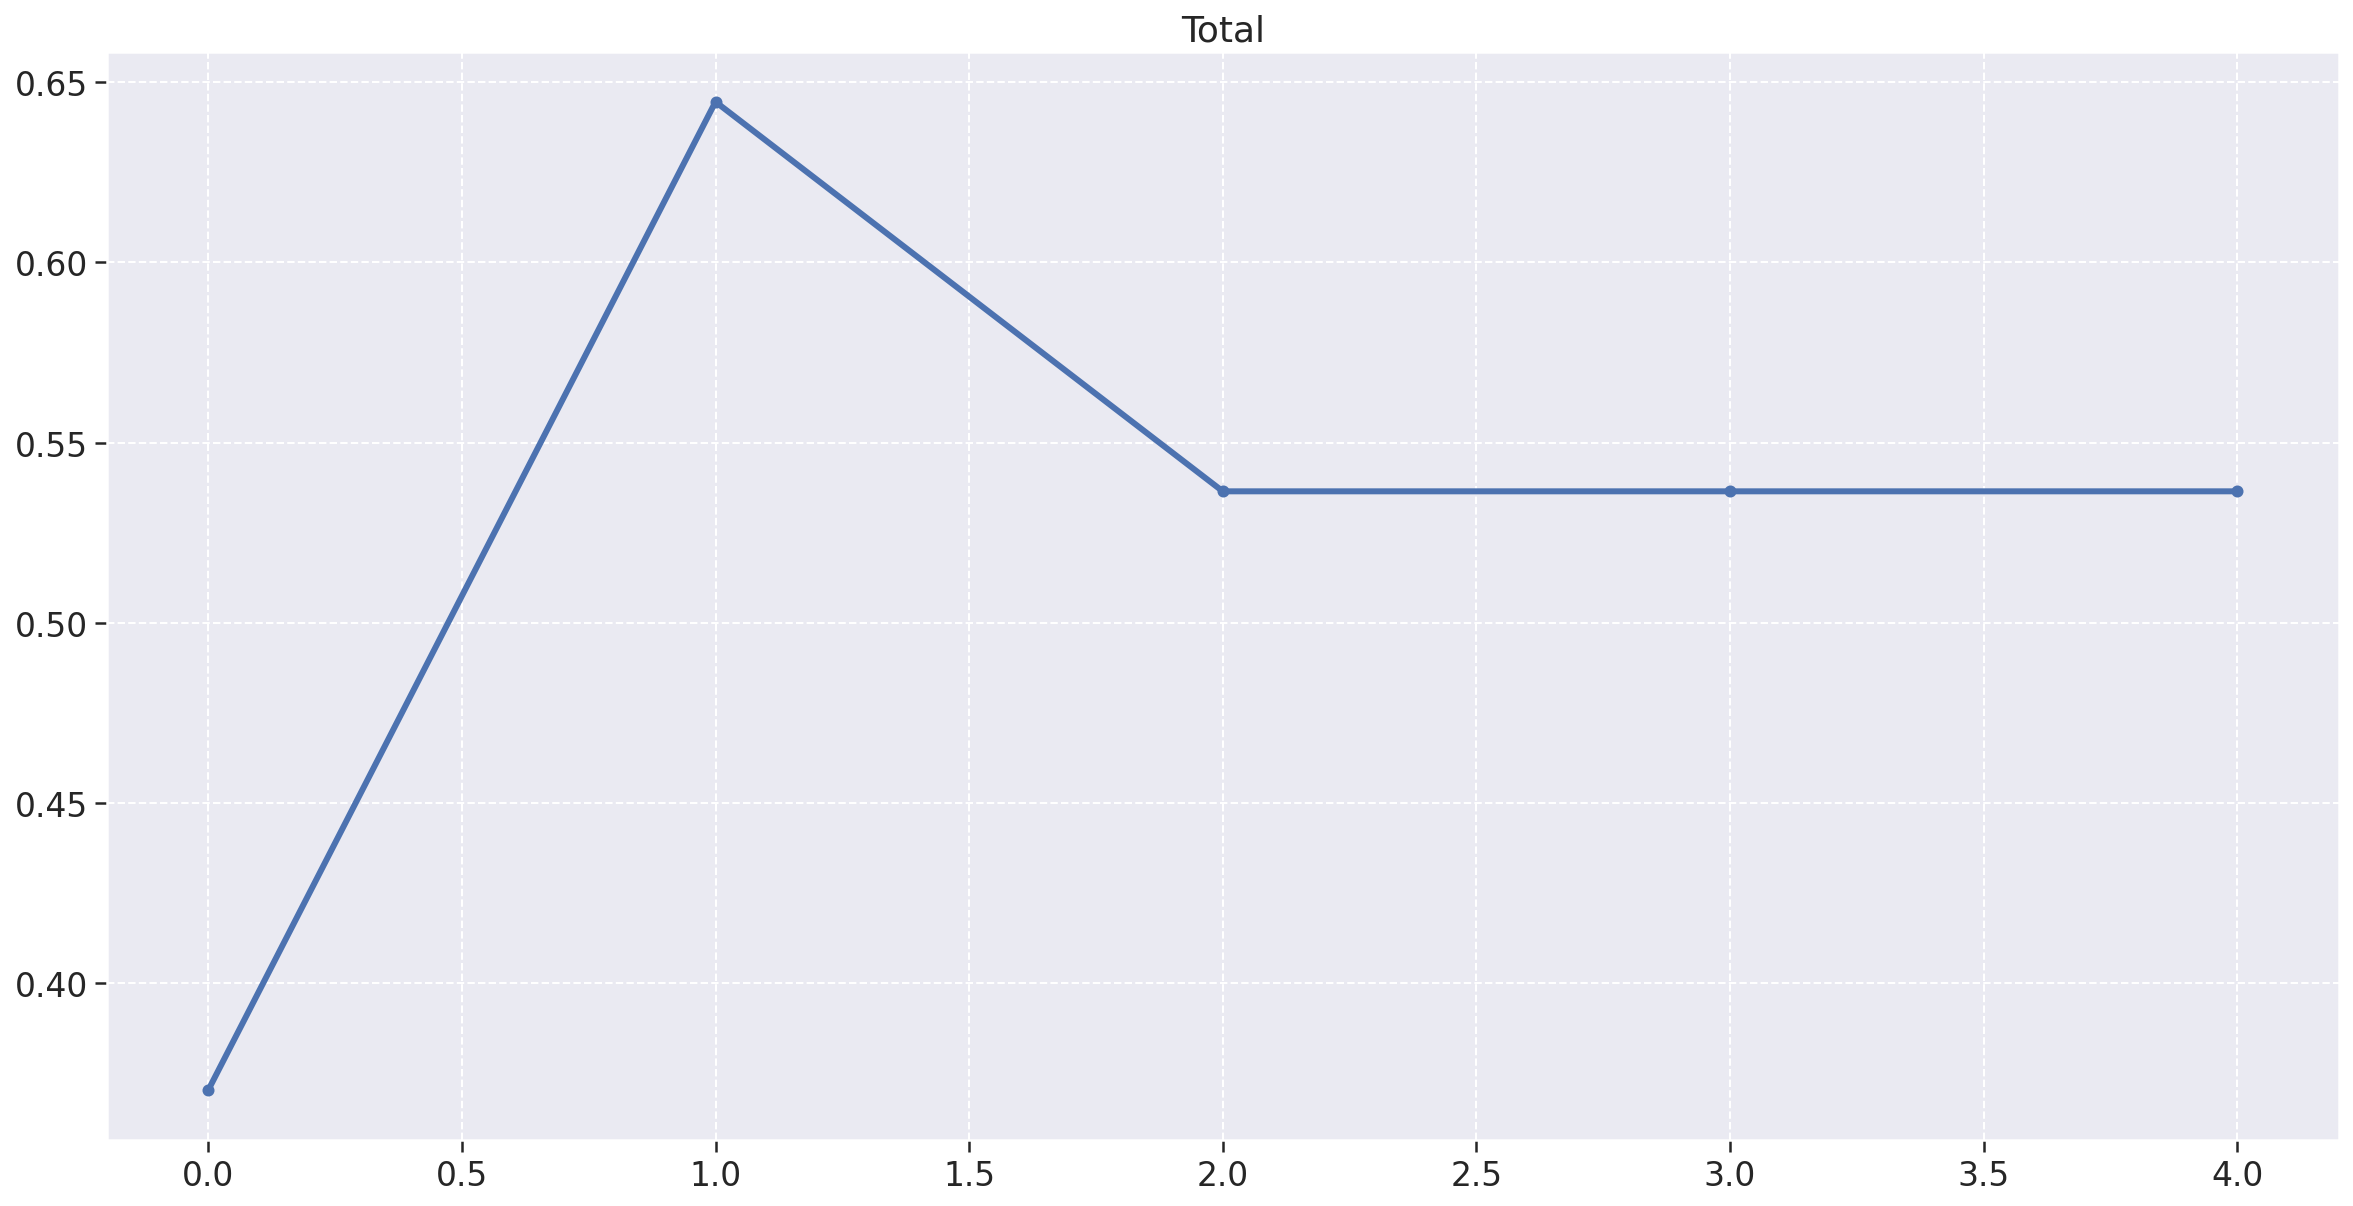

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)
# plt.ylim(.65,.9)

In [36]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

# metrics_df.to_excel('data/fga-eps-mds-Eu-Pescador-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-Eu-Pescador-DATASET-{}.csv'.format(currentTime), index = False)

In [37]:
descriptive_statistics_df = pd.DataFrame()

descriptive_statistics_df['mode_reliability'] = metrics_df['reliability'].mode()
descriptive_statistics_df['mode_maintainability'] = metrics_df['maintainability'].mode()
descriptive_statistics_df['median_reliability'] = metrics_df['reliability'].median()
descriptive_statistics_df['median_maintainability'] = metrics_df['maintainability'].median()
descriptive_statistics_df['mean_reliability'] = metrics_df['reliability'].mean()
descriptive_statistics_df['mean_maintainability'] = metrics_df['maintainability'].mean()
descriptive_statistics_df['max_reliability'] = metrics_df['reliability'].max()
descriptive_statistics_df['max_maintainability'] = metrics_df['maintainability'].max()
descriptive_statistics_df['min_reliability'] = metrics_df['reliability'].min()
descriptive_statistics_df['min_maintainability'] = metrics_df['maintainability'].min()
descriptive_statistics_df['std_dev_reliability'] = metrics_df['reliability'].std()
descriptive_statistics_df['std_dev_maintainability'] = metrics_df['maintainability'].std()
descriptive_statistics_df['variance_reliability'] = metrics_df['reliability'].var()
descriptive_statistics_df['variance_maintainability'] = metrics_df['maintainability'].var()

descriptive_statistics_df

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,0.25,0.286458,0.25,0.286458,0.2325,0.292335,0.3375,0.307083,0.075,0.286458,0.095851,0.009075,0.009187,0.000082


In [38]:
descriptive_statistics_archives = pd.DataFrame()

descriptive_statistics_archives['mode_reliability'] = metrics_df['testing_status'].mode()
descriptive_statistics_archives['mode_maintainability'] = metrics_df['code_quality'].mode()
descriptive_statistics_archives['median_reliability'] = metrics_df['testing_status'].median()
descriptive_statistics_archives['median_maintainability'] = metrics_df['code_quality'].median()
descriptive_statistics_archives['mean_reliability'] = metrics_df['testing_status'].mean()
descriptive_statistics_archives['mean_maintainability'] = metrics_df['code_quality'].mean()
descriptive_statistics_archives['max_reliability'] = metrics_df['testing_status'].max()
descriptive_statistics_archives['max_maintainability'] = metrics_df['code_quality'].max()
descriptive_statistics_archives['min_reliability'] = metrics_df['testing_status'].min()
descriptive_statistics_archives['min_maintainability'] = metrics_df['code_quality'].min()
descriptive_statistics_archives['std_dev_reliability'] = metrics_df['testing_status'].std()
descriptive_statistics_archives['std_dev_maintainability'] = metrics_df['code_quality'].std()
descriptive_statistics_archives['variance_reliability'] = metrics_df['testing_status'].var()
descriptive_statistics_archives['variance_maintainability'] = metrics_df['code_quality'].var()

descriptive_statistics_archives

,mode_reliability,mode_maintainability,median_reliability,median_maintainability,mean_reliability,mean_maintainability,max_reliability,max_maintainability,min_reliability,min_maintainability,std_dev_reliability,std_dev_maintainability,variance_reliability,variance_maintainability
0,0.5,0.572917,0.5,0.572917,0.465,0.58467,0.675,0.614167,0.15,0.572917,0.191703,0.01815,0.03675,0.000329


In [39]:
metrics_df

,m1,m2,m3,m4,m5,m6,m7,repository,version,ncloc,code_quality,testing_status,maintainability,reliability,total
0,0.870588,0.034884,0.883721,0.0,0.0,1.0,0.00,UserInterface,03-18-2022-15-08-02-v1.1.3-devel.0,5458,0.590434,0.150,0.295217,0.0750,0.370217
1,0.750000,0.111111,1.000000,0.0,0.0,1.0,0.75,User,03-18-2022-15-41-53-v2.0.2-devel.0,209,0.614167,0.675,0.307083,0.3375,0.644583
2,0.625000,0.111111,1.000000,0.0,0.0,1.0,0.50,FishWiki,03-18-2022-00-13-24-v2.0.5-devel.0,343,0.572917,0.500,0.286458,0.2500,0.536458
3,0.625000,0.111111,1.000000,0.0,0.0,1.0,0.50,FishWiki,03-18-2022-14-14-54-v2.0.4-devel.0,343,0.572917,0.500,0.286458,0.2500,0.536458
4,0.625000,0.111111,1.000000,0.0,0.0,1.0,0.50,FishLog,03-18-2022-15-28-02-v2.1.1-devel.0,384,0.572917,0.500,0.286458,0.2500,0.536458


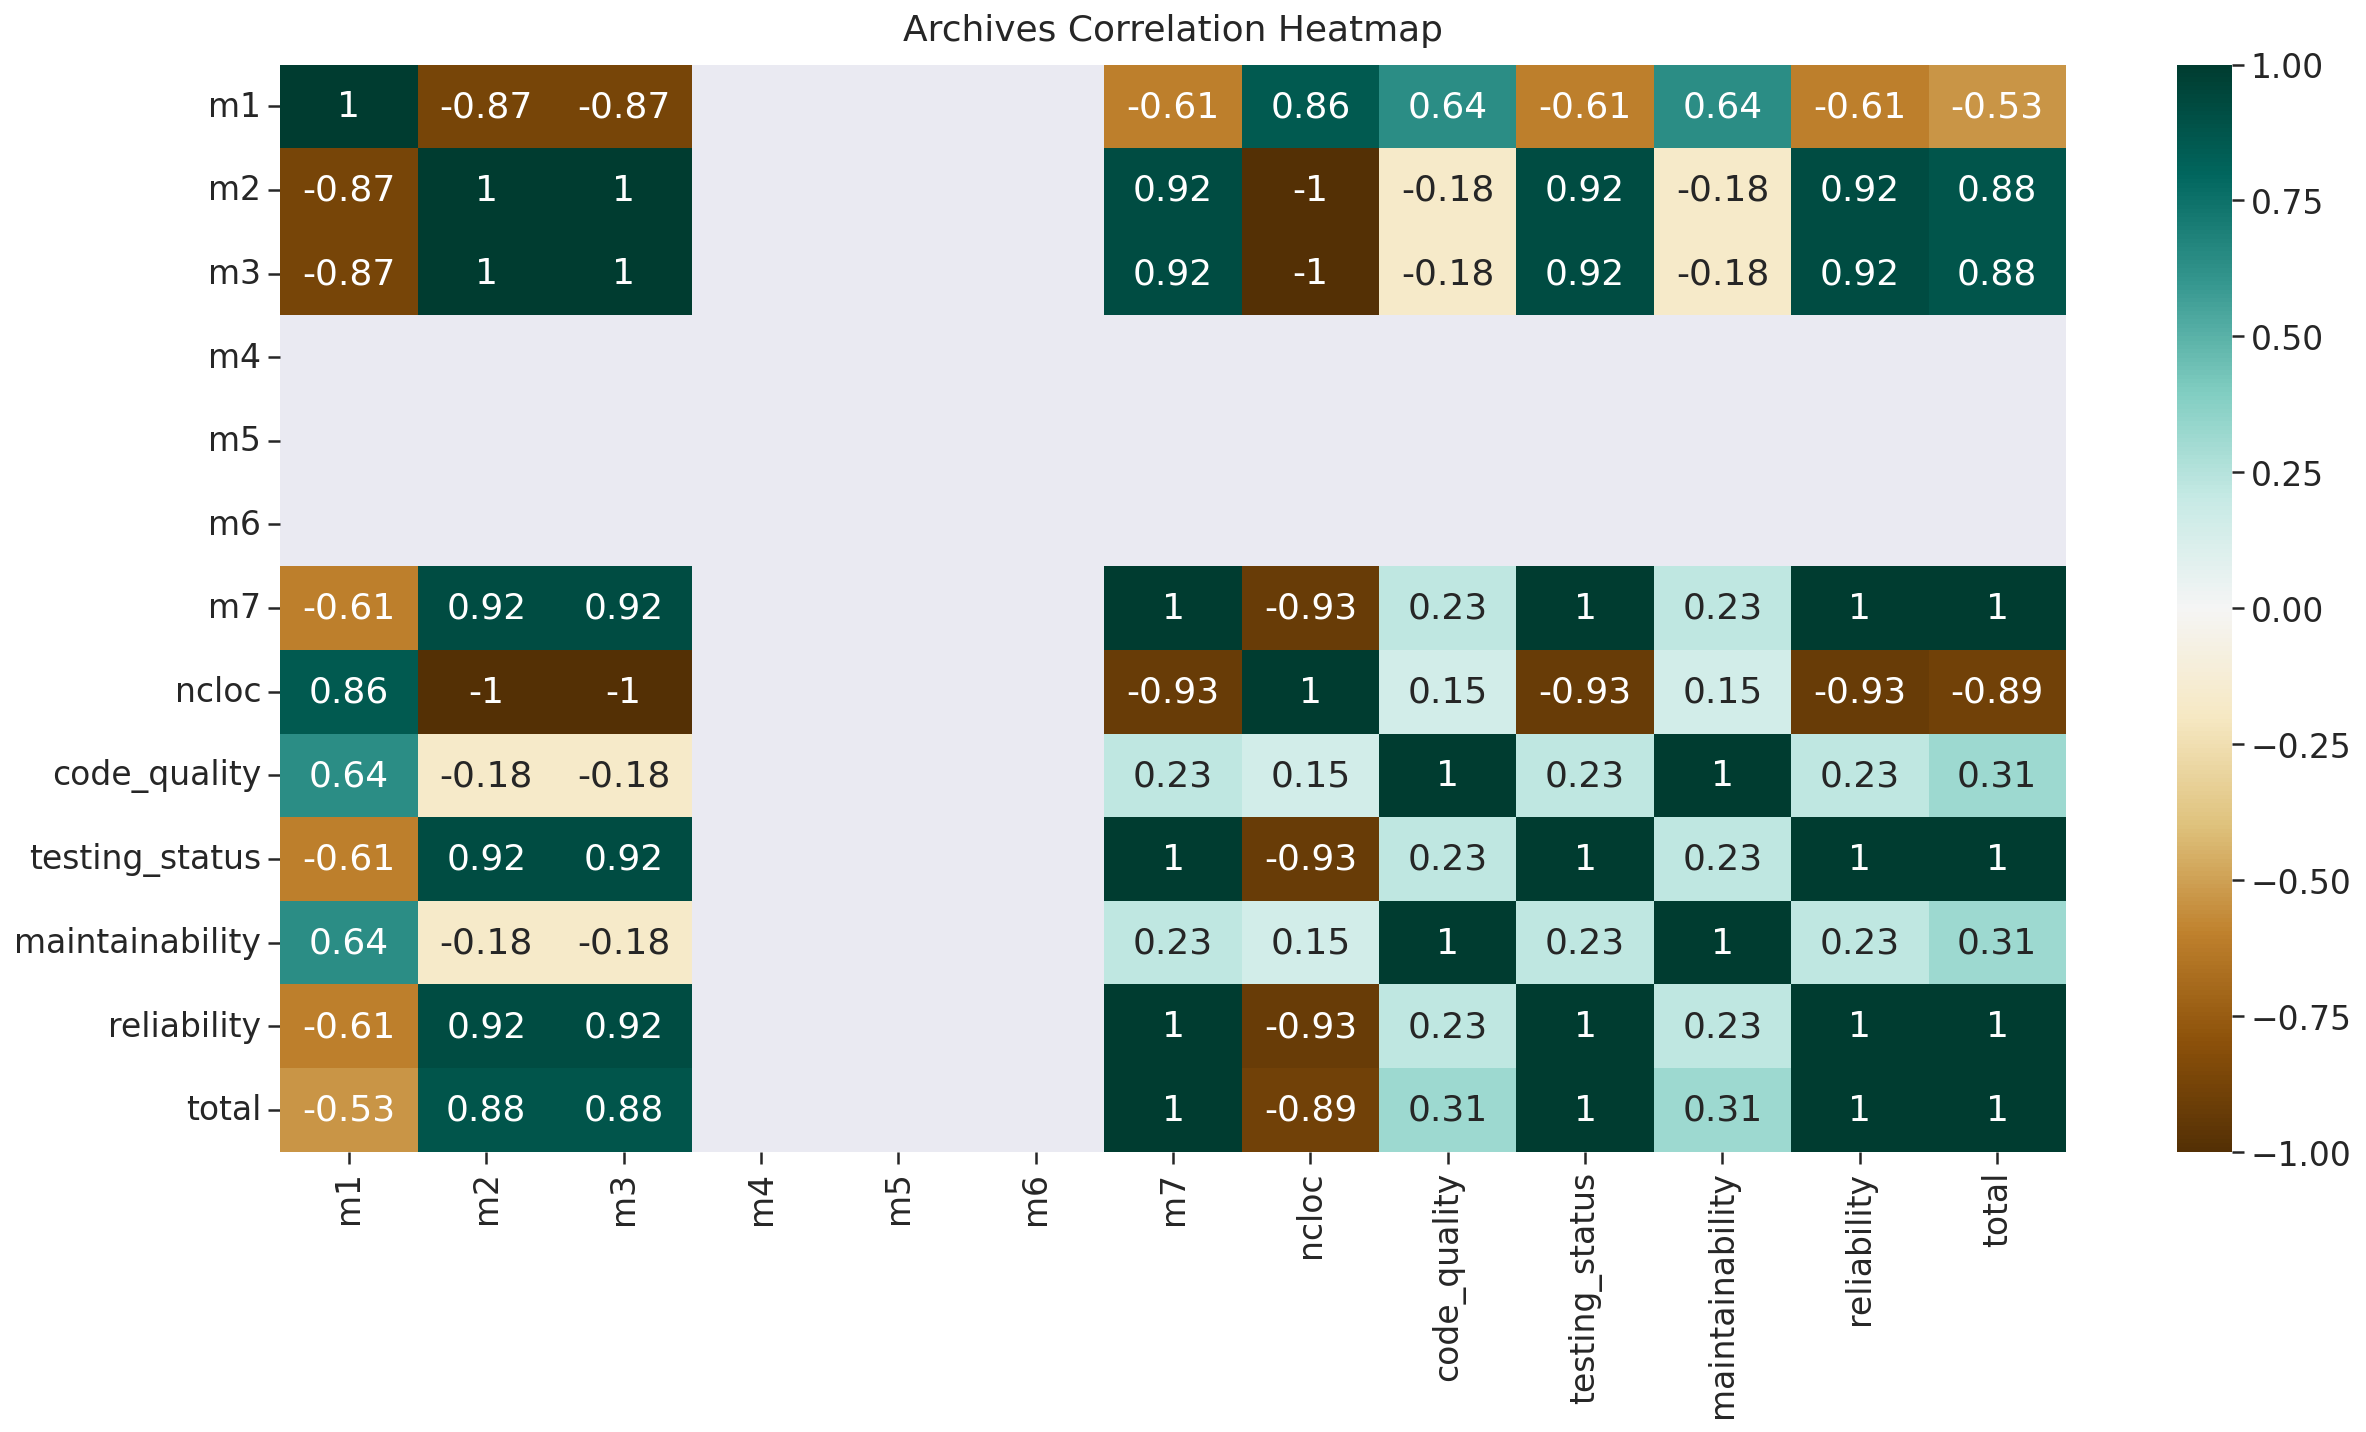

In [40]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(metrics_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Archives Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

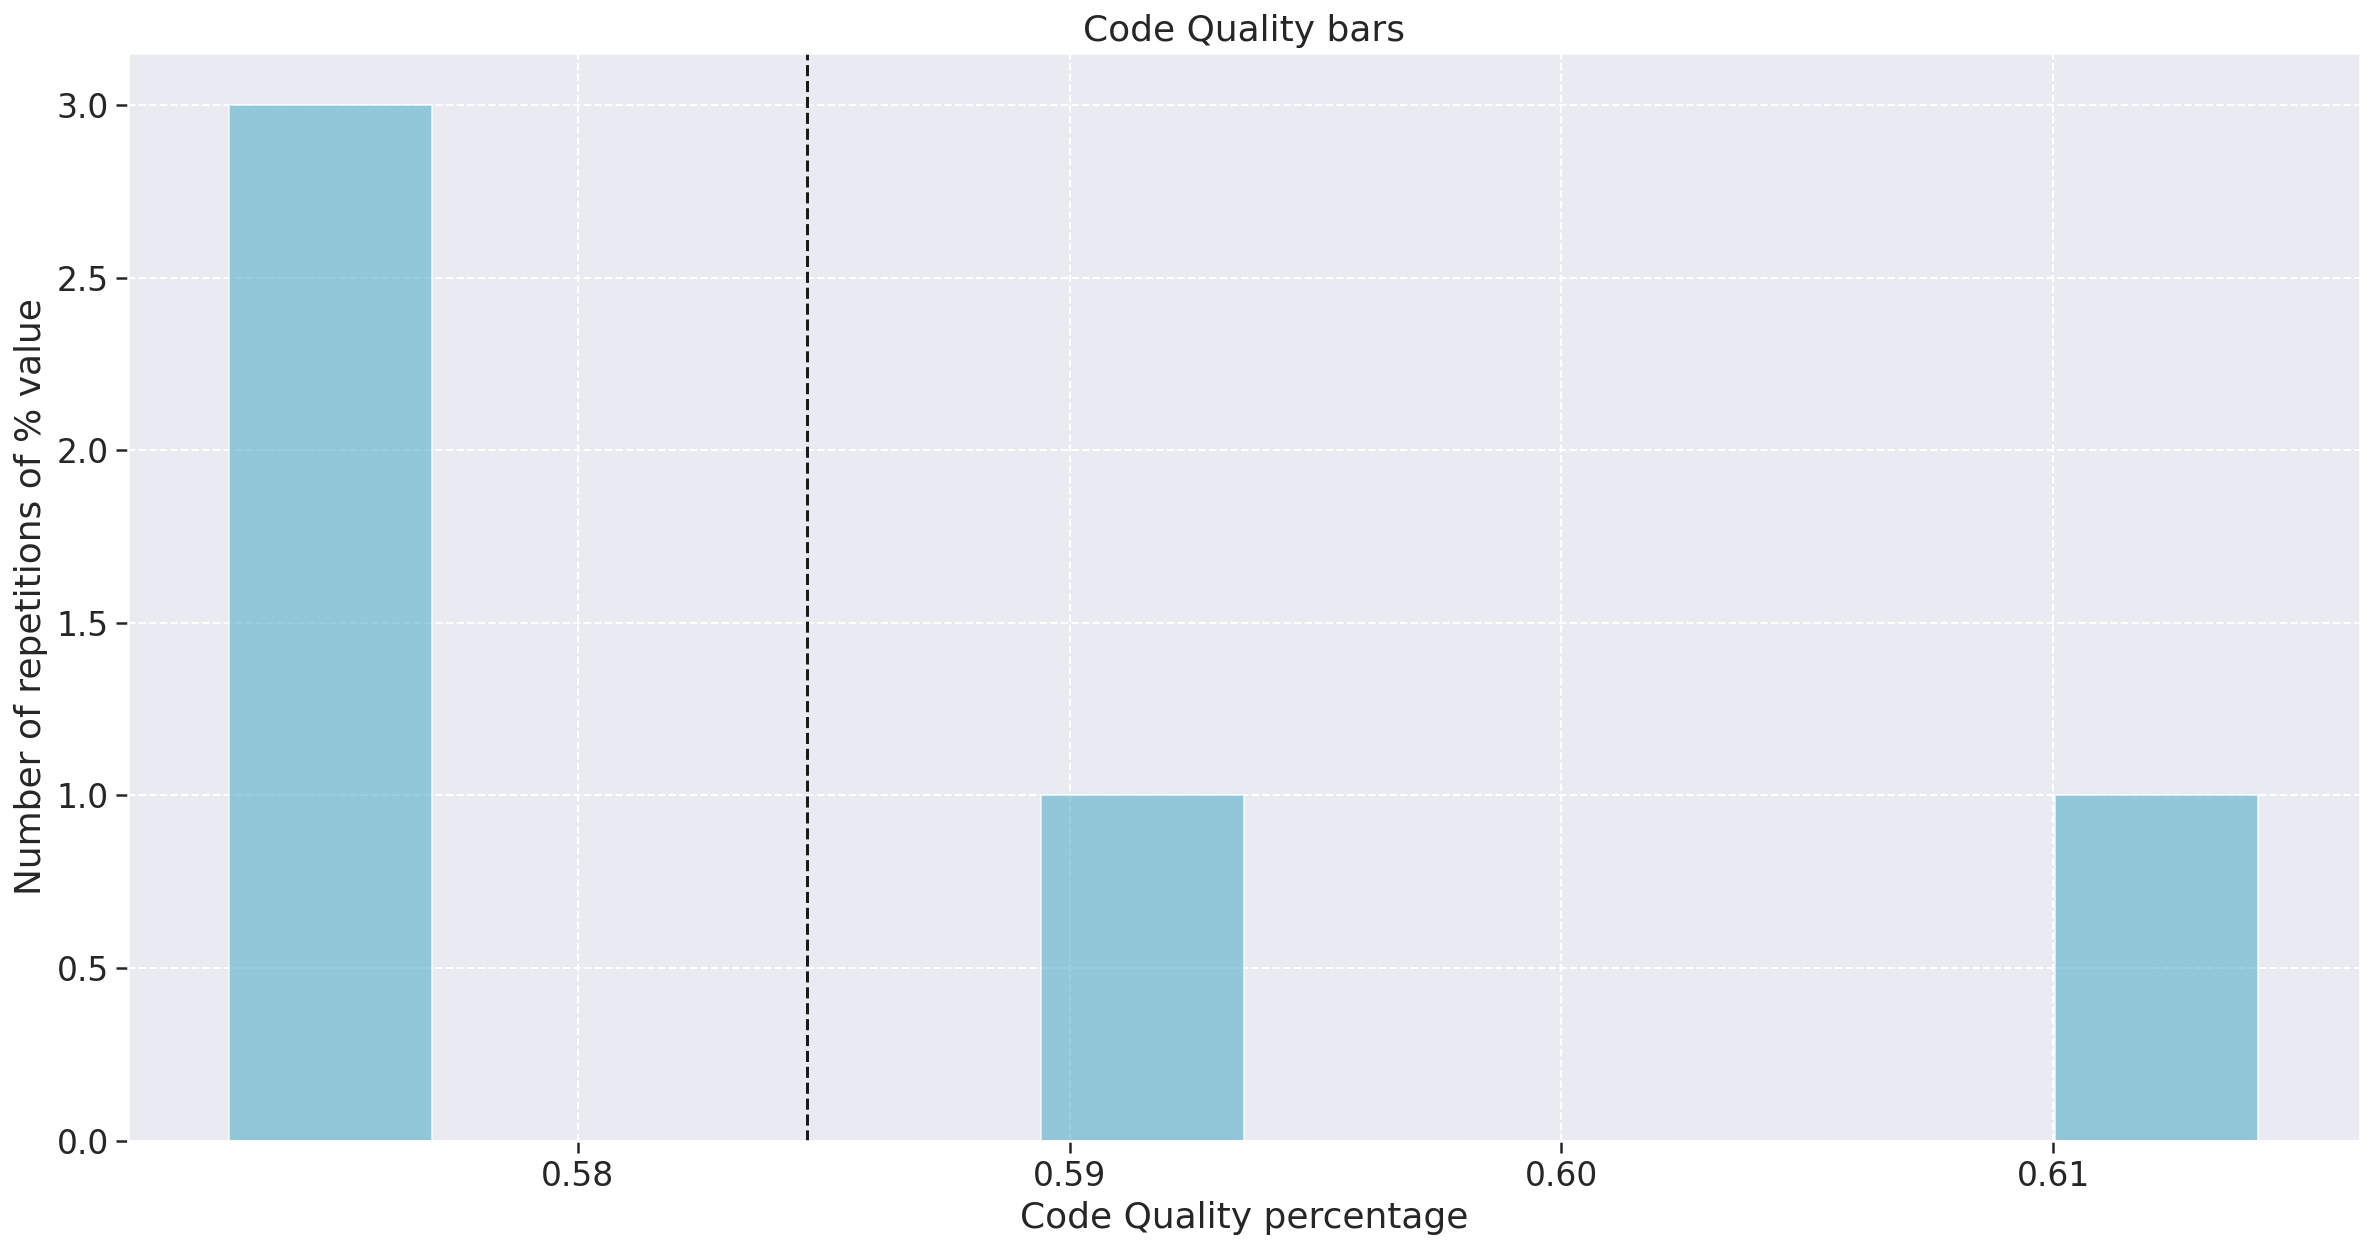

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.title("Code Quality bars")
plt.ylabel("Number of repetitions of % value")
plt.xlabel("Code Quality percentage")
plt.hist(metrics_df['code_quality'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['code_quality'].mean(), color='k', linestyle='dashed')

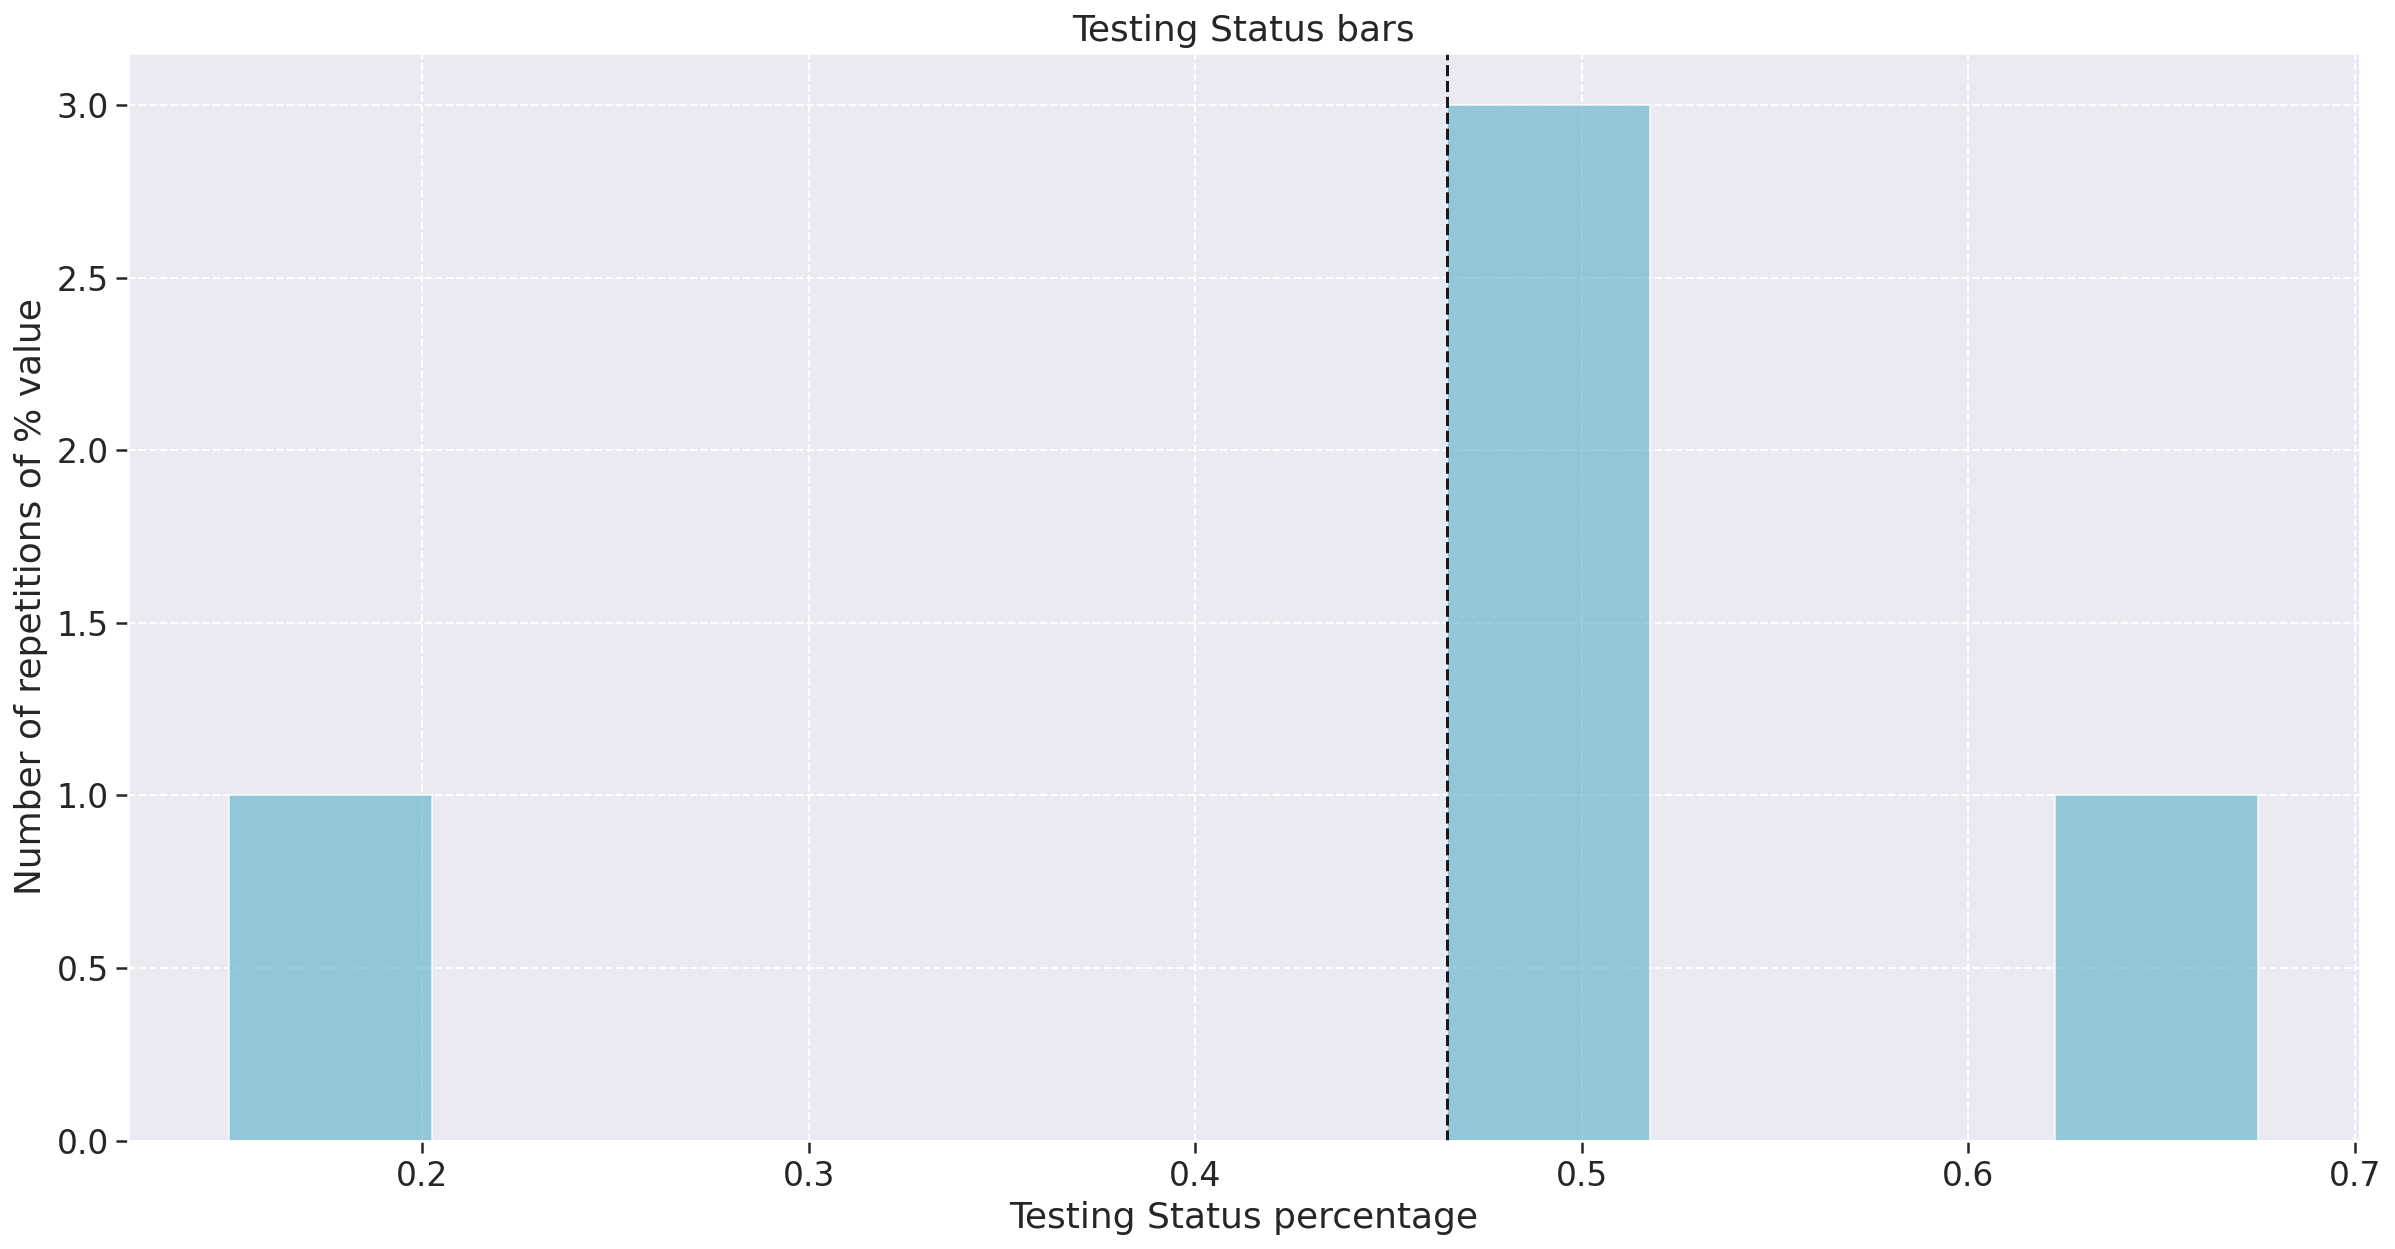

In [42]:

fig = plt.figure(figsize=(20, 10))

plt.title("Testing Status bars")
plt.ylabel("Number of repetitions of % value")
plt.xlabel("Testing Status percentage")
plt.hist(metrics_df['testing_status'], bins=10, color='c', alpha=0.65)
plt.axvline(metrics_df['testing_status'].mean(), color='k', linestyle='dashed')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f791f4c9f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f791f4d85b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f791f4c9ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f791f4d8d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f791f4e80d0>],
 'means': []}

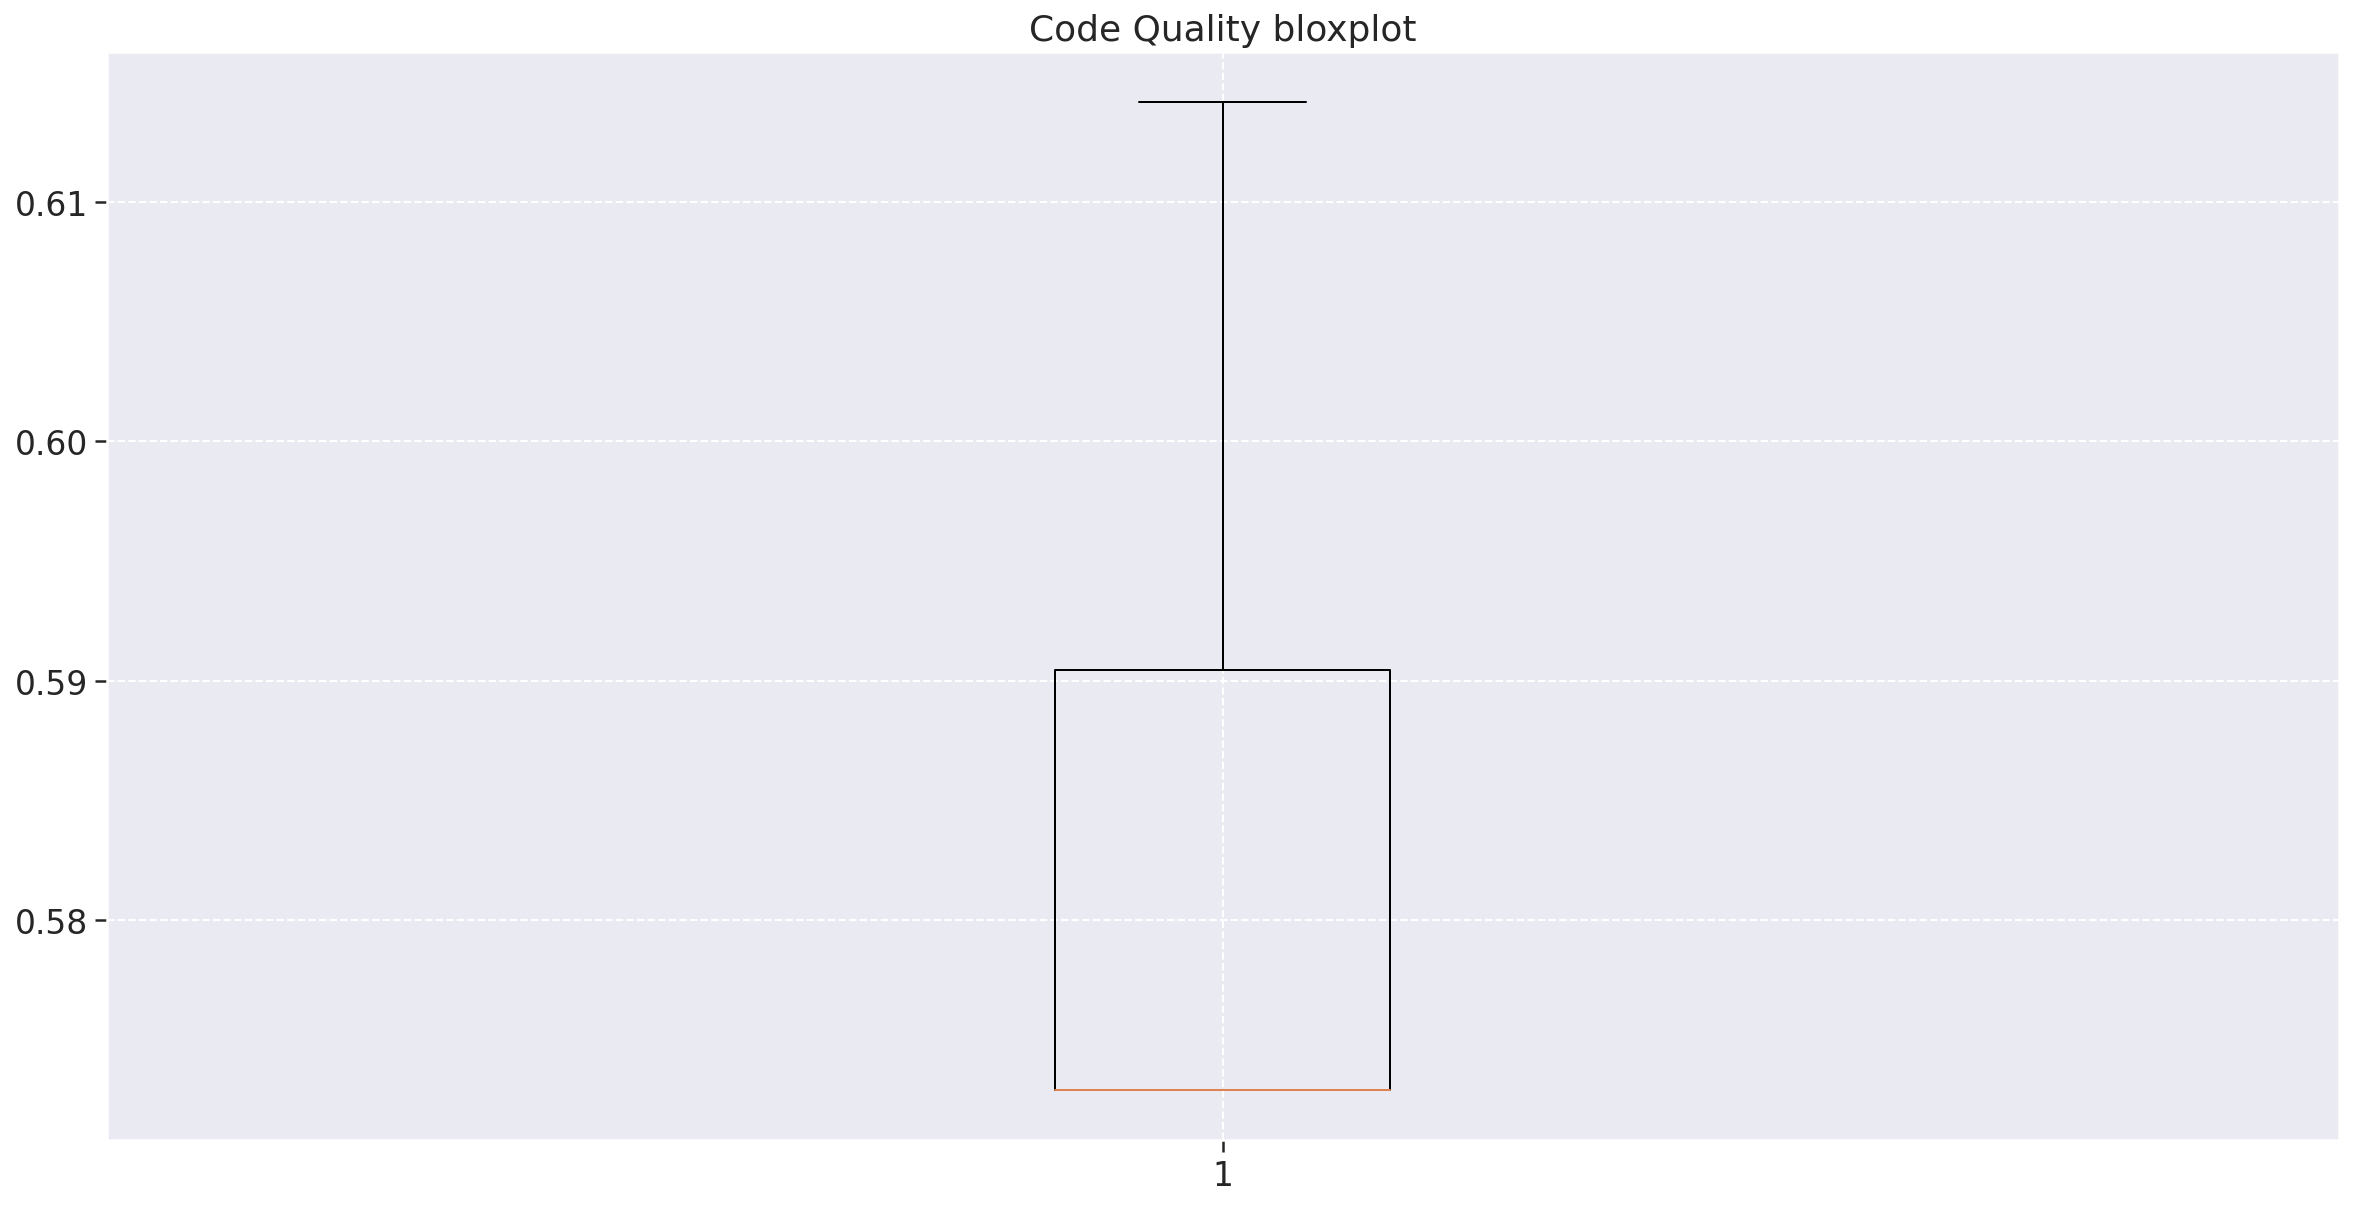

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.title("Code Quality bloxplot")
plt.boxplot(metrics_df['code_quality'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f791f4afdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f791f440550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f791f4afa60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f791f440c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f791f44b040>],
 'means': []}

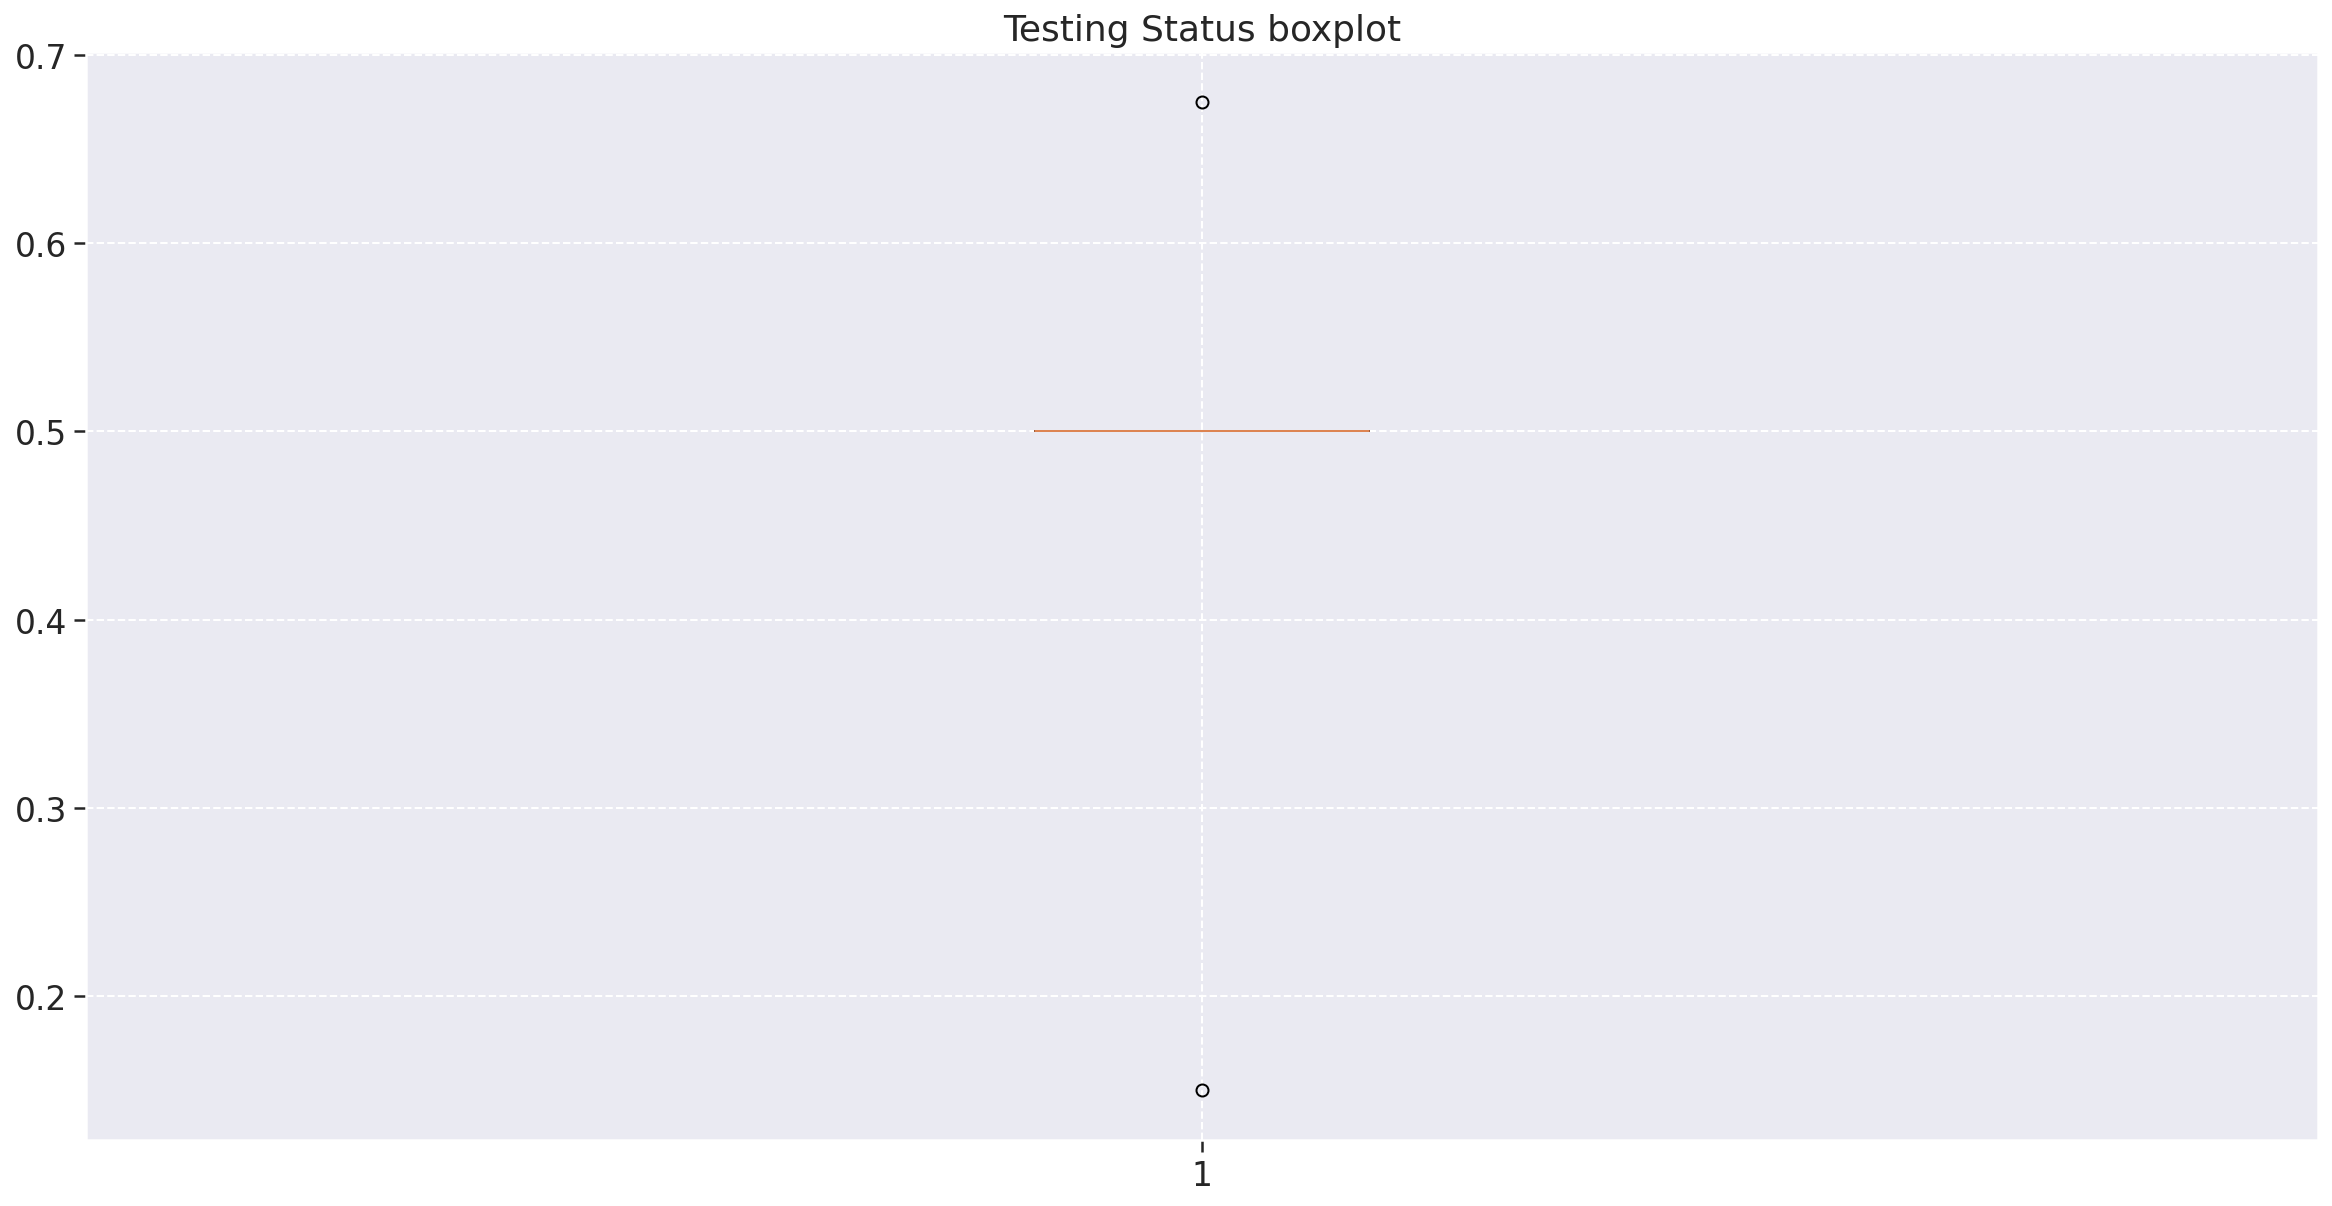

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.title("Testing Status boxplot")
plt.boxplot(metrics_df['testing_status'])